{'Channels_Coupling': {'amplitude': [], 'channels': []},
 'Noise': {'channel': [], 'index': [], 'slope': []},
 'Pulse': {'amplitude': [], 'channel': [], 'index': []},
 'Seasonality': {'amplitude': [5,
                               7,
                               8,
                               19,
                               8,
                               16,
                               7,
                               19,
                               11,
                               18,
                               15,
                               16,
                               5,
                               10,
                               18,
                               18,
                               16,
                               6,
                               8,
                               11],
                 'channel': [6,
                             10,
                             11,
                             16,
         

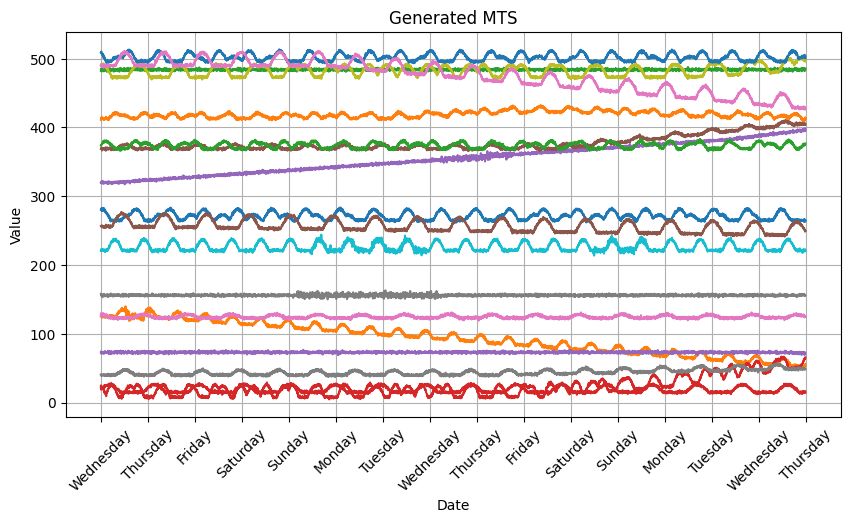

In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib
# matplotlib.use('Agg')
from dataGen import Gen
from utils import compare, experiment
from train import slidingWindow, criterion, train, test, objective, train_vae
from Encoders import LongShort_TCVAE_Encoder, RnnEncoder, MST_VAE_Encoder, MST_VAE_Encoder_dist
from Decoders import LongShort_TCVAE_Decoder, RnnDecoder, MST_VAE_Decoder, MST_VAE_Decoder_dist
from vae import VariationalAutoencoder, VQ_MST_VAE, VQ_Quantizer

import torch; torch.manual_seed(955)
import torch.optim as optim
import torch.distributions as D
from torch.utils.data import DataLoader
# import optuna
# from optuna.samplers import TPESampler
# import torchaudio

import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as D


import numpy as np
import matplotlib.pyplot as plt
import pprint
# all parameters for generating the time series should be configured in this cell
periode = 15 #days
step = 5 # mess interval in minutes
val = 500
n_channels = 18
effects = {
    "Pulse": {
        "occurances":0,
        "max_amplitude":1.5,   
        "interval":40
        },
    "Trend": {
        "occurances":15,
        "max_slope":0.005,
        "type":"linear"
        },
    "Seasonality": {
        "occurances":20,
        "frequency_per_week":(7, 14), # min and max occurances per week
        "amplitude_range":(5, 20),
        },
    "std_variation": {
        "occurances":6,
        "max_value":10,
        "interval":1000,
        },
    "channels_coupling":{
        "occurances":0,
        "coupling_strengh":20
        },
    "Noise": {
        "occurances":0,
        "max_slope":0.005,
        "type":"linear"
        }
    }

X = Gen(periode, step, val, n_channels, effects)
x, params, e_params = X.parameters()
# pprint.pprint(params)
pprint.pprint(e_params)
X.show()

def lin_size(n, num_layers, first_kernel = None):
    
    for i in range(0, num_layers):
        
        if i == 0 and first_kernel != None:
            n = 1 + ((n - first_kernel) // 2)
        else:
            n = 1 + ((n - 2) // 2)
            
    if n <= 0:
        raise ValueError("Window Length is too small in relation to the number of Layers")
            
    return n * 2 * num_layers

class TCVAE_Encoder(nn.Module):
    def __init__(self, input_size, num_layers, latent_dims, L = 30, slope = 0.2, first_kernel = None):
        super(TCVAE_Encoder, self).__init__()   
        
        self.n =  lin_size(L, num_layers, first_kernel)        
        self.cnn_layers = nn.ModuleList()
        self.n_channels = input_size
        
        def init_weights(m):
            if isinstance(m, nn.Conv1d):
                torch.nn.init.kaiming_uniform_(m.weight, mode="fan_in", nonlinearity="leaky_relu")
                m.bias.data.fill_(0.01)
                
        # CNN Layers that double the channels each time
        for i in range(0, num_layers):            
            if i == 0:
                if first_kernel == None: first_kernel = 2
                self.cnn_layers.append(nn.Conv1d(input_size, input_size * 2, kernel_size=first_kernel, stride=2, padding=0))
                self.cnn_layers.append(nn.LeakyReLU(slope, True))
                self.cnn_layers.append(nn.BatchNorm1d(input_size * 2))
            else:                
                self.cnn_layers.append(nn.Conv1d(input_size * 2 * i, input_size * 2 * (i+1), kernel_size=2, stride=2, padding=0))
                self.cnn_layers.append(nn.LeakyReLU(slope, True))
                self.cnn_layers.append(nn.BatchNorm1d(input_size * 2 * (i+1)))
                
        # MLP Layers for Mu and logvar output
        self.encoder_mu = nn.Sequential(
            nn.Linear(self.n * input_size, latent_dims*n_channels),
#             nn.Linear(self.n * input_size, self.n * input_size),
#             nn.ReLU(True)
        )
        self.encoder_logvar = nn.Sequential(
            nn.Linear(self.n * input_size, latent_dims*n_channels),
#             nn.Linear(self.n * input_size, self.n * input_size),
#             nn.ReLU(True)
        )   
        
        #Init CNN
        self.cnn_layers.apply(init_weights)
         
    def forward(self, x):
        ### CNN
        for i, cnn in enumerate(self.cnn_layers):
#             print("Encoder Cnn", x.shape)
            x = cnn(x)
        cnn_shape = x.shape
        x = x.view(x.size(0), -1)
#         print("Encoder reshape after Cnn ", x.shape)
        ### MLP
        mu = self.encoder_mu(x)  
        logvar = self.encoder_logvar(x)
#         print("Encoder mu after lin ", mu.shape)
        mu = mu.view(mu.shape[0], self.n_channels, -1)
        logvar = logvar.view(logvar.shape[0], self.n_channels, -1)
#         print("Encoder mu after reshape ", mu.shape)
#         mu.reshape

        
        return mu, logvar
    
class LongShort_TCVAE_Encoder(nn.Module):
    def __init__(self, input_size, num_layers, latent_dims, L = 30, slope = 0.2, first_kernel = None):
        super(LongShort_TCVAE_Encoder, self).__init__() 
        self.latent_dims = latent_dims
        
        self.short_encoder = TCVAE_Encoder(input_size, num_layers, latent_dims, L, slope, first_kernel= None)
        self.long_encoder = TCVAE_Encoder(input_size, num_layers, latent_dims, L, slope, first_kernel)
        
    def forward(self, x):        
        short_mu, short_logvar = self.short_encoder(x)        
        long_mu, long_logvar = self.long_encoder(x)

        mu = torch.cat((short_mu, long_mu), axis=1)
        logvar = torch.cat((short_logvar, long_logvar), axis=1)
        
#         print("Short Encoder mu: ", short_mu.shape)
#         print("Long Encoder mu: ", long_mu.shape)
        
#         print("After Cat: ", mu.shape)
        
        
        return mu, logvar
    
class VQ_Quantizer(nn.Module):
    def __init__(self, num_embed, dim_embed, commit_loss, decay, epsilon=1e-5):
        super(VQ_Quantizer, self).__init__()  
        
        self._num_embed = num_embed
        self._dim_embed = dim_embed
        self._commit_loss = commit_loss
        
        self._embedding = nn.Embedding(self._num_embed, self._dim_embed)
        self._embedding.weight.data.uniform_(-1/self._num_embed, 1/self._num_embed)      
        
        self.register_buffer('_ema_cluster_size', torch.zeros(num_embed))
        self._ema_w = nn.Parameter(torch.Tensor(num_embed, dim_embed))
        self._ema_w.data.normal_()
        
        self._decay = decay
        self._epsilon = epsilon

    def forward(self, x):
        # x : BCL -> BLC
#         print(x.shape)
        x = x.permute(0,2,1).contiguous()
        x_shape = x.shape
        
        # flaten the input to have the Channels as embedding space
        x_flat = x.view(-1, self._dim_embed)
        
        # Calculate the distance to embeddings
        
#         print("the non squared x", x_flat.shape )
#         print("the non squared embed weights", self._embedding.weight.t().shape)
#         print("the x ", torch.sum(x_flat**2, dim = 1, keepdim = True).shape)
#         print("the embed ", torch.sum(self._embedding.weight**2, dim = 1).shape)
#         print("the matmul ", torch.matmul(x_flat, self._embedding.weight.t()).shape)
        dist = (torch.sum(x_flat**2, dim = 1, keepdim = True) 
               + torch.sum(self._embedding.weight**2, dim = 1)
               - 2 * torch.matmul(x_flat, self._embedding.weight.t()))
#         print(dist.shape)
        
        embed_indices = torch.argmin(dist, dim = 1).unsqueeze(1)
#         print(embed_indices)
        embed_Matrix = torch.zeros_like(dist)
#         print(embed_Matrix.shape)
        embed_Matrix.scatter_(1, embed_indices, 1)
#         print("Embedding ", embed_Matrix[:10,:])

        # get the corresponding e vectors
        quantizer = torch.matmul(embed_Matrix, self._embedding.weight).view(x_shape)   
        
        # Use EMA to update the embedding vectors
        if self.training:
            self._ema_cluster_size = self._ema_cluster_size * self._decay + \
                                     (1 - self._decay) * torch.sum(embed_Matrix, 0)
            
            # Laplace smoothing of the cluster size
            n = torch.sum(self._ema_cluster_size.data)
            self._ema_cluster_size = (
                (self._ema_cluster_size + self._epsilon)
                / (n + self._num_embed * self._epsilon) * n)
            
            dw = torch.matmul(embed_Matrix.t(), x_flat)
            self._ema_w = nn.Parameter(self._ema_w * self._decay + (1 - self._decay) * dw)
            
            self._embedding.weight = nn.Parameter(self._ema_w / self._ema_cluster_size.unsqueeze(1))
#         print("quantizer ", quantizer.shape)
        
        # Loss
#         first_loss = F.mse_loss(quantizer, x.detach())
#         second_loss = F.mse_loss(quantizer.detach(), x)
#         loss = first_loss + self._commit_loss * second_loss
        
         # Loss EMA
        e_loss = F.mse_loss(quantizer.detach(), x)
        loss = self._commit_loss * e_loss
#         print(loss)
        
        # straigh-through gradient
        quantizer = x + (quantizer -x).detach()
        quantizer = quantizer.permute(0,2,1).contiguous()
#         print("quantizer ", quantizer.shape)       
     
        return quantizer, loss
    
class VQ_MST_VAE(nn.Module):
    def __init__(self, n_channels, num_layers, latent_dims, v_encoder, v_decoder, v_quantizer,
                 L = 30,
                 slope = 0.2,
                 first_kernel = None,
                 commit_loss = 0.25
                ):
        super(VQ_MST_VAE, self).__init__()
        
        self._n_channels = n_channels
        self._num_layers = num_layers
        self._latent_dims = latent_dims
        self._v_encoder = v_encoder
        self._v_decoder = v_decoder
        self._v_quantizer = v_quantizer
        self._L = L
        self._slope = slope
        self._first_kernel = first_kernel
        self._commit_loss = commit_loss
        
        
        self.encoder = self._v_encoder(self._n_channels, self._num_layers, self._latent_dims, self._L, self._slope, self._first_kernel)
        self.decoder = self._v_decoder(self._n_channels, self._num_layers, self._latent_dims, self._L, self._slope, self._first_kernel)
        self.quantizer = self._v_quantizer(self._latent_dims, self._n_channels,self._commit_loss, decay=0.99, epsilon=1e-5)
        
    def reparametrization_trick(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std
    
    def forward(self, x):
        mu, logvar = self.encoder(x)                
        
        z = self.reparametrization_trick(mu, logvar)
        
        e, loss_quantize = self.quantizer(z)

#         mu_dec, logvar_dec = self.decoder(e)
#         x_rec = self.reparametrization_trick(mu_dec, mu_dec)
        x_rec = self.decoder(e)
        loss_rec = F.mse_loss(x_rec, x, reduction='sum')
        loss = loss_rec + loss_quantize
#         print("----------------Encoder Output-------------")
#         print("mu and logvar", mu.shape, logvar.shape)
#         print("----------------Reparametrization-------------")
#         print("Z", z.shape)
#         print("----------------Quantizer-------------")
#         print("quantized shape", e.shape)
#         print("loss shape", loss_quantize)
#         print("----------------Decoding-------------")
        #print("----------------Decoder Output-------------")
#         print("mu and logvar Decoder", mu_dec.shape, logvar_dec.shape)
        #print("rec shape", x_rec.shape)
        return x_rec, loss, mu, logvar 

In [2]:
class TCVAE_Decoder(nn.Module):
    def __init__(self, input_size, num_layers, latent_dims, L = 30, slope = 0.2, first_kernel = None):
        super(TCVAE_Decoder, self).__init__() 
        
        def init_weights(m):
            if isinstance(m, nn.Conv1d):
                torch.nn.init.kaiming_uniform_(m.weight, mode="fan_in", nonlinearity="leaky_relu")
                m.bias.data.fill_(0.01)
                
        self.input_size = input_size
        self.latent_dims = latent_dims
        self.first_kernel = first_kernel
        self.num_layers = num_layers
        
        self.n =  lin_size(L, num_layers, first_kernel)
        
        
        
        self.cnn_layers = nn.ModuleList()
        
        if self.first_kernel == None: first_kernel = 2
        else: first_kernel = self.first_kernel
        input_lin = self.latent_dims  * 2 ** (self.num_layers-1) + first_kernel - 2
#         print(input_lin)
        self.decoder_lin = nn.Linear(input_lin, L)
        
#         # CNN Layers that double the channels each time
#         for i in range(num_layers, 0, -1):            
#             if i == 1:
#                 if first_kernel == None: first_kernel = 2
#                 self.cnn_layers.append(nn.ConvTranspose1d(input_size * 2, input_size, kernel_size=2, stride=2, padding=0))
#                 self.cnn_layers.append(nn.LeakyReLU(slope, True))
#             else:                
#                 self.cnn_layers.append(nn.ConvTranspose1d(input_size * 2 * i, input_size * 2 * (i-1), kernel_size=2, stride=2, padding=0))
#                 self.cnn_layers.append(nn.LeakyReLU(slope, True))
#                 self.cnn_layers.append(nn.BatchNorm1d(input_size * 2 * (i-1)))     
                
                
        # CNN Layers that double the channels each time
        for i in range(0, num_layers):            
            if i == 0:
                if first_kernel == None: first_kernel = 2
                self.cnn_layers.append(nn.ConvTranspose1d(input_size*2, input_size, kernel_size=2, stride=2, padding=0))
                self.cnn_layers.append(nn.LeakyReLU(slope, True))
                self.cnn_layers.append(nn.BatchNorm1d(input_size))
            elif i == num_layers -1:
                if first_kernel == None: first_kernel = 2
                self.cnn_layers.append(nn.ConvTranspose1d(input_size, input_size, kernel_size=first_kernel, stride=2, padding=0))
                self.cnn_layers.append(nn.LeakyReLU(slope, True))
                self.cnn_layers.append(nn.BatchNorm1d(input_size))
            else:                
                self.cnn_layers.append(nn.ConvTranspose1d(input_size , input_size, kernel_size=2, stride=2, padding=0))
                self.cnn_layers.append(nn.LeakyReLU(slope, True))
                self.cnn_layers.append(nn.BatchNorm1d(input_size))
        
        # Init CNN
        self.cnn_layers.apply(init_weights)
                
        
    def forward(self, x):
#         print("Decoder Input ", z.shape)
#         x = x.view(x.shape[0], x.shape[1]* x.shape[2], -1)
#         print("Decoder Input reshaped ",x.shape)
#         x = self.decoder_lin(z) 
#         print("Decoder Input after lin ",x.shape)
#         x = x.view(x.shape[0],x.shape[1],1)
#         print("Decoder Input reshaped again",x.shape)
       
        for i, cnn in enumerate(self.cnn_layers):
#             print("Decoder Cnn ", x.shape)
            x = cnn(x)
#         print("Decoder shape after Cnn, should be reshaped? ", x.shape)
        x = self.decoder_lin(x)
#         print("Decoder after lin ", x.shape)

        return x #x[:,:,0]

In [3]:
class LongShort_TCVAE_Decoder(nn.Module):
    def __init__(self, input_size, num_layers, latent_dims, L = 30, slope = 0.2, first_kernel = None):
        super(LongShort_TCVAE_Decoder, self).__init__()  
        
        self.longshort_decoder = TCVAE_Decoder(input_size, num_layers, 2 * latent_dims, L, slope, first_kernel)
        self.short_decoder = TCVAE_Decoder(input_size, num_layers, 2 * latent_dims, L, slope, first_kernel = None)
        
        self.reduction_layer = nn.Conv1d(2* input_size, input_size, kernel_size=1, stride=1, padding=0)
        
    def forward(self, z):
        x_long= self.longshort_decoder(z)
        x_short = self.short_decoder(z)
#         print("x_long ", x_long.shape)
#         print("x_short ",x_short.shape)
        
        x_cat = torch.cat((x_short, x_long), dim = 1)     # B.2C.L
#         print("x_cat ",x_cat.shape)
        
        x_red = self.reduction_layer(x_cat)
#         print("x_red ",x_red.shape)
        return x_red

In [4]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
class slidingWindow(Dataset):
    def __init__(self, data, L):
        self.data = data
        self.L = L

    def __getitem__(self, index):
        if self.data.shape[1] - index >= self.L:            
            x = self.data[:,index:index+self.L]    
            v = torch.sum(x/self.L, axis=1).unsqueeze(1)
#             print(x.shape)
#             print(v.unsqueeze(1).shape)
            x = x/v
            return (x, v)
        
    def __len__(self):
        return self.data.shape[1] - self.L
    
### Cost function
def criterion(recon_x, x, mu, logvar):
    ### reconstruction loss
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')

    ### KL divergence loss
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    ### total loss
    loss = recon_loss + 1*kld_loss
    return loss

def sample_mean(model, batch, n):
    batch_size = batch.shape[0]
    n_channels = batch.shape[1]
    latent_dims = model.encoder.latent_dims
    L = model._L

    mu, logvar = (torch.empty((batch_size, 2 * n_channels, latent_dims, 0)).to(batch) for _ in range(2))
    REC = torch.empty(batch_size, n_channels, L, 0).to(batch)
#     print(REC.shape)
#     print(mu.shape)

    for i in range(n):
        rec, _mu, _logvar = model(batch)

        REC = torch.cat((REC, rec.unsqueeze(-1)), dim=-1)
        mu = torch.cat((mu, _mu.unsqueeze(-1)), dim=-1)
        logvar = torch.cat((logvar, _logvar.unsqueeze(-1)), dim=-1)

    # print("shapes after cat: mu, logvar, REC ", mu.shape, logvar.shape, REC.shape)
    mu, logvar = (torch.mean(t, dim=-1) for t in [mu, logvar])
    REC = torch.mean(REC, dim=-1)
    #     print("shapes after mean: mu, logvar, REC ", mu.shape, logvar.shape, REC.shape)

    return REC, mu, logvar

def train(model, train_loader, criterion, optimizer, device, epoch, VQ = True):
    model.train()
    train_loss = 0

    for batch_idx, (data, v) in enumerate(train_loader):
        
        data = data.to(device)
        v = v.to(device)
        optimizer.zero_grad()        

        if VQ:
            x_rec, loss, mu, logvar = model(data)
        else:
#             x_rec, mu, logvar = model(data)
            x_rec, mu, logvar = sample_mean(model, data, 10)
            if v.dim() == 1:
                v = v.unsqueeze(-1)
                v = v.unsqueeze(-1)
            # x_rec_window_length = x_rec.shape[2]
            loss = criterion((x_rec*v)[:,:,0], data[:,:,0], mu, logvar)
        # print(x_rec.shape)
        # print(data[:, :, 0].shape)
        loss.backward()

        optimizer.step()
        train_loss += loss.item()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))
    
    return  train_loss / len(train_loader.dataset)

In [5]:
### Init Model
latent_dims = 6 # 6 # 17
L= 32# 39 #32
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# v = vae(n_channels, L, latent_dims)
# v = VariationalAutoencoder(input_size = n_channels,
#                       hidden_size = 30,
#                       num_layers = 3,
#                       latent_dims= latent_dims,
#                       v_encoder = LongShort_TCVAE_Encoder, #MST_VAE_Encoder, # RnnEncoder, LongShort_TCVAE_Encoder,
#                       v_decoder = LongShort_TCVAE_Decoder, #MST_VAE_Decoder, # RnnDecoder, LongShort_TCVAE_Decoder,
#                       L = L,
#                       slope = 0.2,
#                       first_kernel = 21)
v = VQ_MST_VAE(n_channels = n_channels,
                            num_layers =  3,#4, #3
                            latent_dims= latent_dims,
                            v_encoder = LongShort_TCVAE_Encoder, #MST_VAE_Encoder,
                            v_decoder = LongShort_TCVAE_Decoder, #MST_VAE_Decoder,
                            v_quantizer = VQ_Quantizer,
                            L=L,
                            slope = 0,
                            first_kernel = 20, #11, #20
                            commit_loss = 10) #10 5
enc = MST_VAE_Encoder_dist(     n_channels,
                           num_layers = 3,
                           slope = 0.2,
                           first_kernel = 15)
dec = MST_VAE_Decoder_dist(     n_channels,
                           num_layers = 3,
                           slope = 0.2,
                           first_kernel = 15)


v = v.to(device)
enc = enc.to(device)
dec = dec.to(device)
opt = optim.Adam(v.parameters(), lr = 0.005043529186448577) # 0.005043529186448577 0.006819850049647945
print(v)
# Create the dictionaries of probability distributions
# pnet = {'z': D.Normal(loc=torch.zeros(latent_dims), scale=torch.ones(latent_dims)), 'x': dec}
# qnet = {'z': enc}
# serie = torch.tensor(serie).float()
x = torch.FloatTensor(x)

# x = F.normalize(x, p=2, dim=1)
n = x.shape[1]
# L = 30

train_ = x[:, :int(0.8*n)]
val_   = x[:, int(0.8*n):int(0.9*n)]
test_  = x[:, int(0.9*n):]

train_data = DataLoader(slidingWindow(train_, L),
                        batch_size= 22,# 59, # 22
                        shuffle = False
                        )
val_data = DataLoader(slidingWindow(val_, L),
                        batch_size=22,
                        shuffle = False
                        )
test_data = DataLoader(slidingWindow(test_, L),
                        batch_size=22,
                        shuffle = False
                        )

VQ_MST_VAE(
  (encoder): LongShort_TCVAE_Encoder(
    (short_encoder): TCVAE_Encoder(
      (cnn_layers): ModuleList(
        (0): Conv1d(18, 36, kernel_size=(2,), stride=(2,))
        (1): LeakyReLU(negative_slope=0, inplace=True)
        (2): BatchNorm1d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Conv1d(36, 72, kernel_size=(2,), stride=(2,))
        (4): LeakyReLU(negative_slope=0, inplace=True)
        (5): BatchNorm1d(72, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (6): Conv1d(72, 108, kernel_size=(2,), stride=(2,))
        (7): LeakyReLU(negative_slope=0, inplace=True)
        (8): BatchNorm1d(108, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (encoder_mu): Sequential(
        (0): Linear(in_features=432, out_features=108, bias=True)
      )
      (encoder_logvar): Sequential(
        (0): Linear(in_features=432, out_features=108, bias=True)
      )
    )
    (long_encoder): TCVAE_Enc

In [6]:
for epoch in range(1, 100):
    train(v, train_data, criterion, opt, device, epoch, VQ = True)

Train Epoch: 1 [0/3424 (0%)]	Loss: 653.854093
Train Epoch: 1 [2200/3424 (64%)]	Loss: 4.271423
====> Epoch: 1 Average loss: 32.8374
Train Epoch: 2 [0/3424 (0%)]	Loss: 2.899753
Train Epoch: 2 [2200/3424 (64%)]	Loss: 2.654329
====> Epoch: 2 Average loss: 2.3568
Train Epoch: 3 [0/3424 (0%)]	Loss: 2.301791
Train Epoch: 3 [2200/3424 (64%)]	Loss: 2.161158
====> Epoch: 3 Average loss: 1.9662
Train Epoch: 4 [0/3424 (0%)]	Loss: 1.968993
Train Epoch: 4 [2200/3424 (64%)]	Loss: 1.628983
====> Epoch: 4 Average loss: 1.6954
Train Epoch: 5 [0/3424 (0%)]	Loss: 1.673311
Train Epoch: 5 [2200/3424 (64%)]	Loss: 1.462567
====> Epoch: 5 Average loss: 1.5112
Train Epoch: 6 [0/3424 (0%)]	Loss: 1.469343
Train Epoch: 6 [2200/3424 (64%)]	Loss: 1.414980
====> Epoch: 6 Average loss: 1.4458
Train Epoch: 7 [0/3424 (0%)]	Loss: 1.384571
Train Epoch: 7 [2200/3424 (64%)]	Loss: 1.160502
====> Epoch: 7 Average loss: 1.3057
Train Epoch: 8 [0/3424 (0%)]	Loss: 1.137348
Train Epoch: 8 [2200/3424 (64%)]	Loss: 1.113034
====> Epo

Train Epoch: 64 [2200/3424 (64%)]	Loss: 0.419366
====> Epoch: 64 Average loss: 0.4524
Train Epoch: 65 [0/3424 (0%)]	Loss: 0.430150
Train Epoch: 65 [2200/3424 (64%)]	Loss: 0.416621
====> Epoch: 65 Average loss: 0.4314
Train Epoch: 66 [0/3424 (0%)]	Loss: 0.396748
Train Epoch: 66 [2200/3424 (64%)]	Loss: 0.413012
====> Epoch: 66 Average loss: 0.4348
Train Epoch: 67 [0/3424 (0%)]	Loss: 0.551401
Train Epoch: 67 [2200/3424 (64%)]	Loss: 0.473447
====> Epoch: 67 Average loss: 0.4723
Train Epoch: 68 [0/3424 (0%)]	Loss: 0.511724
Train Epoch: 68 [2200/3424 (64%)]	Loss: 0.521230
====> Epoch: 68 Average loss: 0.5438
Train Epoch: 69 [0/3424 (0%)]	Loss: 0.442926
Train Epoch: 69 [2200/3424 (64%)]	Loss: 0.418992
====> Epoch: 69 Average loss: 0.4530
Train Epoch: 70 [0/3424 (0%)]	Loss: 0.407206
Train Epoch: 70 [2200/3424 (64%)]	Loss: 0.405849
====> Epoch: 70 Average loss: 0.4389
Train Epoch: 71 [0/3424 (0%)]	Loss: 0.419891
Train Epoch: 71 [2200/3424 (64%)]	Loss: 0.380825
====> Epoch: 71 Average loss: 0.41

In [7]:
def compare(dataset, model, VQ=True):
    model.eval()
    rec = []
    x = []
    with torch.no_grad():
        for i, (data, v) in enumerate(dataset):
            if VQ:
                x_rec, loss, mu, logvar = model(data)
            else:
                x_rec, mu, logvar = model(data)
            z = model.reparametrization_trick(mu, logvar)
            if v.dim() == 1:
                v = v.unsqueeze(0)
                v = v.T
                v = v.unsqueeze(-1)
#             print(v.shape)
#             print(x_rec.shape)
#             print((x_rec * v).shape)
#             print(i)

            x.extend((data*v)[:,:,0].detach().numpy())
            rec.extend(((x_rec*v)[:,:,0]).detach().numpy())
        
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(rec, "r--")
    ax.plot(x[:], "b-")
    blue_handle = plt.Line2D([], [], color='b', label='Original Data')
    red_handle = plt.Line2D([], [], color='r', label='Reconstructions mean')
#     ax.set_title('Reconstruction of Train Data')
    ax.set_title('Prediction of Test (unseen) Data')
    ax.legend(handles=[blue_handle, red_handle], loc="upper right")
    ax.set_xlabel('Time')
    ax.set_ylabel('Values')
#     plt.ylim(0,2)
    plt.grid(True)
    plt.show()

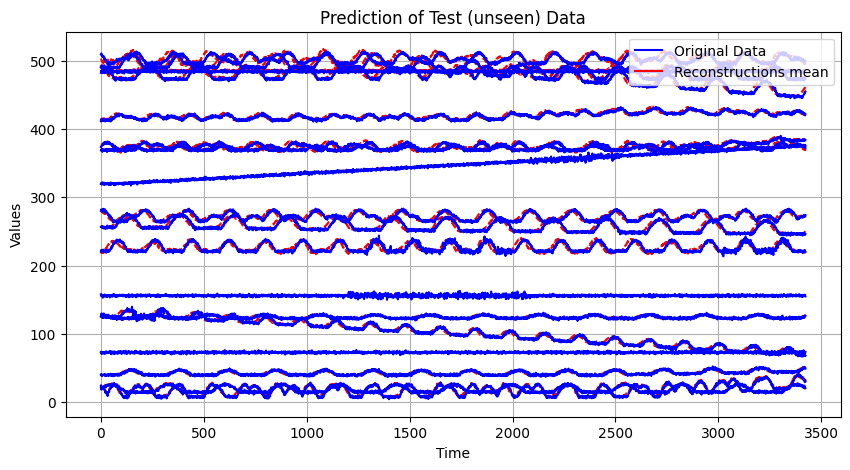

VQ_MST_VAE(
  (encoder): LongShort_TCVAE_Encoder(
    (short_encoder): TCVAE_Encoder(
      (cnn_layers): ModuleList(
        (0): Conv1d(18, 36, kernel_size=(2,), stride=(2,))
        (1): LeakyReLU(negative_slope=0, inplace=True)
        (2): BatchNorm1d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Conv1d(36, 72, kernel_size=(2,), stride=(2,))
        (4): LeakyReLU(negative_slope=0, inplace=True)
        (5): BatchNorm1d(72, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (6): Conv1d(72, 108, kernel_size=(2,), stride=(2,))
        (7): LeakyReLU(negative_slope=0, inplace=True)
        (8): BatchNorm1d(108, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (encoder_mu): Sequential(
        (0): Linear(in_features=432, out_features=108, bias=True)
      )
      (encoder_logvar): Sequential(
        (0): Linear(in_features=432, out_features=108, bias=True)
      )
    )
    (long_encoder): TCVAE_Enc

In [8]:
v.cpu()
compare(train_data, v, VQ=True)
v.to(device)

In [36]:
def plot_heatmap(ax_heatmap, codebook):
    ax_heatmap.clear()
    heatmap = ax_heatmap.imshow(codebook)
    ax_heatmap.set_title('Codebook Heatmap')
    ax_heatmap


    return heatmap
def create_heatmap(codebook):
    fig, ax_heatmap = plt.subplots(figsize=(12, 6), dpi=100)
    heatmap = plot_heatmap(ax_heatmap, codebook)
#     heatmap_canvas = FigureCanvasTkAgg(fig, master=heatmap_frame)
#     heatmap_canvas.draw()
#     heatmap_canvas.get_tk_widget().pack(fill="both", expand=True)
    cbar = fig.colorbar(heatmap)
    ax_heatmap.set_xlabel('Num of Embeddings')
    ax_heatmap.set_ylabel('Latent Dimensions')
    
    return ax_heatmap
    

(6, 18)

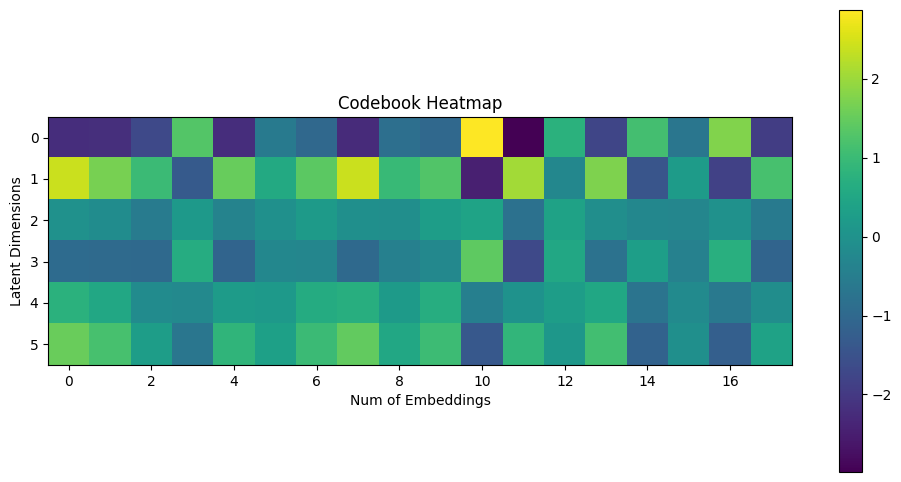

In [38]:
from matplotlib.figure import Figure
codebook = v.quantizer._embedding.weight.cpu().detach().numpy()
heatmap = create_heatmap(codebook)
codebook.shape


In [39]:
def objective(trial, model, x, criterion_fcn, train_fcn, n_channels, epochs):
    # Define the hyperparameters to optimize
    learning_rate = trial.suggest_uniform('learning_rate', 1e-5, 1e-2)
    num_layers = trial.suggest_int('num_layers', 3, 7)
    latent_dims = trial.suggest_int('latent_dims', 2, 20)
    first_kernel = trial.suggest_int('first_kernel', 10, 30)
    slope = trial.suggest_int('slope', 0.1, 0.3)
    commit_loss = trial.suggest_int('commit_loss', 0.1, 10)
    L = trial.suggest_int('L', 30, 512)
    batch_size = trial.suggest_int('batch_size', 10, 100)
    ### Init Model

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    n = x.shape[1]
    train_ = x[:, :int(0.8*n)]
    val_   = x[:, int(0.8*n):int(0.9*n)]
    test_  = x[:, int(0.9*n):]

    train_data = DataLoader(slidingWindow(train_, L),
                            batch_size=batch_size,
                            shuffle = False
                            )
    val_data = DataLoader(slidingWindow(val_, L),
                            batch_size=batch_size,
                            shuffle = False
                            )
    test_data = DataLoader(slidingWindow(test_, L),
                            batch_size=batch_size,
                            shuffle = False
                            )

    v = VQ_MST_VAE(n_channels = n_channels,
                            num_layers = num_layers,
                            latent_dims= latent_dims,
                            v_encoder = LongShort_TCVAE_Encoder, #MST_VAE_Encoder,
                            v_decoder = LongShort_TCVAE_Decoder, #MST_VAE_Decoder,
                            v_quantizer = VQ_Quantizer,
                            L=L,
                            slope = slope,
                            first_kernel = first_kernel,
                            commit_loss = 10)
    v = v.to(device)
    # Define the loss function and optimizer
    optimizer = optim.Adam(v.parameters(), lr=learning_rate)

    for epoch in range(1, epochs):
        loss = train_fcn(v, train_data, criterion_fcn, optimizer, device, epoch, VQ=True)


    # Return the validation accuracy as the objective value
    return loss

In [47]:
import optuna
from optuna.samplers import TPESampler
# Define the Optuna study and optimize the hyperparameters
epochs = 50
study = optuna.create_study(sampler=TPESampler(), direction='minimize')
study.optimize(lambda trial: objective(trial,
                                       VariationalAutoencoder,
                                       x,                                         
                                       criterion, 
                                       train,                                        
                                       n_channels,
                                       epochs
                                      ),
               n_trials=50)

[I 2023-05-02 17:59:36,234] A new study created in memory with name: no-name-30fb0dc7-ef13-4d97-875a-9665d7a3d940
/tmp/ipykernel_26901/3092515310.py:3: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_uniform('learning_rate', 1e-5, 1e-2)


Train Epoch: 1 [0/2955 (0%)]	Loss: 10143.938776
====> Epoch: 1 Average loss: 2024977706.8132
Train Epoch: 2 [0/2955 (0%)]	Loss: 4764746806000.326172
====> Epoch: 2 Average loss: 174559738763.1687
Train Epoch: 3 [0/2955 (0%)]	Loss: 977693.959184
====> Epoch: 3 Average loss: 223993748098.3513
Train Epoch: 4 [0/2955 (0%)]	Loss: 2421406239.346939
====> Epoch: 4 Average loss: 40166869.8161
Train Epoch: 5 [0/2955 (0%)]	Loss: 6628.145408
====> Epoch: 5 Average loss: 2600.2351
Train Epoch: 6 [0/2955 (0%)]	Loss: 1987.888393
====> Epoch: 6 Average loss: 836.0706
Train Epoch: 7 [0/2955 (0%)]	Loss: 1035.992746
====> Epoch: 7 Average loss: 527.6291
Train Epoch: 8 [0/2955 (0%)]	Loss: 756.261798
====> Epoch: 8 Average loss: 442.2395
Train Epoch: 9 [0/2955 (0%)]	Loss: 637.948342
====> Epoch: 9 Average loss: 391.4065
Train Epoch: 10 [0/2955 (0%)]	Loss: 569.841239
====> Epoch: 10 Average loss: 359.5134
Train Epoch: 11 [0/2955 (0%)]	Loss: 520.861886
====> Epoch: 11 Average loss: 333.8632
Train Epoch: 12 

[I 2023-05-02 18:00:47,247] Trial 0 finished with value: 33.7724049421333 and parameters: {'learning_rate': 0.008450139527568372, 'num_layers': 4, 'latent_dims': 7, 'first_kernel': 10, 'slope': 0, 'commit_loss': 1, 'L': 501, 'batch_size': 49}. Best is trial 0 with value: 33.7724049421333.


====> Epoch: 49 Average loss: 33.7724
Train Epoch: 1 [0/3070 (0%)]	Loss: 7818.509115
Train Epoch: 1 [1200/3070 (39%)]	Loss: 2060.528971
Train Epoch: 1 [2400/3070 (78%)]	Loss: 219.387533
====> Epoch: 1 Average loss: 5641338833354.0557
Train Epoch: 2 [0/3070 (0%)]	Loss: 4096816.333333
Train Epoch: 2 [1200/3070 (39%)]	Loss: 195.551005
Train Epoch: 2 [2400/3070 (78%)]	Loss: 756.960775
====> Epoch: 2 Average loss: 346657.3348
Train Epoch: 3 [0/3070 (0%)]	Loss: 1144.705811
Train Epoch: 3 [1200/3070 (39%)]	Loss: 450.866455
Train Epoch: 3 [2400/3070 (78%)]	Loss: 900.216064
====> Epoch: 3 Average loss: 130502.2784
Train Epoch: 4 [0/3070 (0%)]	Loss: 1522.253255
Train Epoch: 4 [1200/3070 (39%)]	Loss: 420.256592
Train Epoch: 4 [2400/3070 (78%)]	Loss: 822.974202
====> Epoch: 4 Average loss: 10182.6151
Train Epoch: 5 [0/3070 (0%)]	Loss: 1013.381510
Train Epoch: 5 [1200/3070 (39%)]	Loss: 361.903605
Train Epoch: 5 [2400/3070 (78%)]	Loss: 769.937256
====> Epoch: 5 Average loss: 16084.5501
Train Epoch: 

Train Epoch: 44 [2400/3070 (78%)]	Loss: 27.225588
====> Epoch: 44 Average loss: 876.5373
Train Epoch: 45 [0/3070 (0%)]	Loss: 412.338989
Train Epoch: 45 [1200/3070 (39%)]	Loss: 20.325558
Train Epoch: 45 [2400/3070 (78%)]	Loss: 28.489517
====> Epoch: 45 Average loss: 315.5933
Train Epoch: 46 [0/3070 (0%)]	Loss: 647.474813
Train Epoch: 46 [1200/3070 (39%)]	Loss: 41.534495
Train Epoch: 46 [2400/3070 (78%)]	Loss: 26.817719
====> Epoch: 46 Average loss: 610.4354
Train Epoch: 47 [0/3070 (0%)]	Loss: 571.763021
Train Epoch: 47 [1200/3070 (39%)]	Loss: 25.176926
Train Epoch: 47 [2400/3070 (78%)]	Loss: 24.011876
====> Epoch: 47 Average loss: 188.1561
Train Epoch: 48 [0/3070 (0%)]	Loss: 182.189657
Train Epoch: 48 [1200/3070 (39%)]	Loss: 26.503807
Train Epoch: 48 [2400/3070 (78%)]	Loss: 24.590080
====> Epoch: 48 Average loss: 474.5152
Train Epoch: 49 [0/3070 (0%)]	Loss: 550.942179
Train Epoch: 49 [1200/3070 (39%)]	Loss: 18.406265
Train Epoch: 49 [2400/3070 (78%)]	Loss: 26.509115


[I 2023-05-02 18:05:12,766] Trial 1 finished with value: 109.43061523934529 and parameters: {'learning_rate': 0.008987872145552423, 'num_layers': 5, 'latent_dims': 15, 'first_kernel': 13, 'slope': 0, 'commit_loss': 5, 'L': 386, 'batch_size': 12}. Best is trial 0 with value: 33.7724049421333.


====> Epoch: 49 Average loss: 109.4306
Train Epoch: 1 [0/3412 (0%)]	Loss: 871.533464
Train Epoch: 1 [3000/3412 (88%)]	Loss: 5.914687
====> Epoch: 1 Average loss: 50.3728
Train Epoch: 2 [0/3412 (0%)]	Loss: 4.152709
Train Epoch: 2 [3000/3412 (88%)]	Loss: 3.321757
====> Epoch: 2 Average loss: 2.6685
Train Epoch: 3 [0/3412 (0%)]	Loss: 1.787410
Train Epoch: 3 [3000/3412 (88%)]	Loss: 2.441556
====> Epoch: 3 Average loss: 1.6182
Train Epoch: 4 [0/3412 (0%)]	Loss: 1.242101
Train Epoch: 4 [3000/3412 (88%)]	Loss: 2.401026
====> Epoch: 4 Average loss: 1.5989
Train Epoch: 5 [0/3412 (0%)]	Loss: 1.097548
Train Epoch: 5 [3000/3412 (88%)]	Loss: 2.540755
====> Epoch: 5 Average loss: 1.5206
Train Epoch: 6 [0/3412 (0%)]	Loss: 1.044534
Train Epoch: 6 [3000/3412 (88%)]	Loss: 1.981078
====> Epoch: 6 Average loss: 1.5550
Train Epoch: 7 [0/3412 (0%)]	Loss: 0.952795
Train Epoch: 7 [3000/3412 (88%)]	Loss: 2.251906
====> Epoch: 7 Average loss: 2.2675
Train Epoch: 8 [0/3412 (0%)]	Loss: 0.908570
Train Epoch: 8 [30

[I 2023-05-02 18:07:05,558] Trial 2 finished with value: 0.36240414731807197 and parameters: {'learning_rate': 0.003524871032596831, 'num_layers': 4, 'latent_dims': 18, 'first_kernel': 19, 'slope': 0, 'commit_loss': 8, 'L': 44, 'batch_size': 30}. Best is trial 2 with value: 0.36240414731807197.


====> Epoch: 49 Average loss: 0.3624
Train Epoch: 1 [0/3288 (0%)]	Loss: 3439.589518
Train Epoch: 1 [2400/3288 (73%)]	Loss: 55.081573
====> Epoch: 1 Average loss: 2079.7879
Train Epoch: 2 [0/3288 (0%)]	Loss: 18.832415
Train Epoch: 2 [2400/3288 (73%)]	Loss: 12.910409
====> Epoch: 2 Average loss: 19.7723
Train Epoch: 3 [0/3288 (0%)]	Loss: 8.927247
Train Epoch: 3 [2400/3288 (73%)]	Loss: 14.027916
====> Epoch: 3 Average loss: 13.6951
Train Epoch: 4 [0/3288 (0%)]	Loss: 13.679026
Train Epoch: 4 [2400/3288 (73%)]	Loss: 9.624182
====> Epoch: 4 Average loss: 16.1600
Train Epoch: 5 [0/3288 (0%)]	Loss: 8.492549
Train Epoch: 5 [2400/3288 (73%)]	Loss: 10.956071
====> Epoch: 5 Average loss: 10.5953
Train Epoch: 6 [0/3288 (0%)]	Loss: 6.499294
Train Epoch: 6 [2400/3288 (73%)]	Loss: 11.081005
====> Epoch: 6 Average loss: 9.8514
Train Epoch: 7 [0/3288 (0%)]	Loss: 9.644265
Train Epoch: 7 [2400/3288 (73%)]	Loss: 138.114258
====> Epoch: 7 Average loss: 123070797.6460
Train Epoch: 8 [0/3288 (0%)]	Loss: 9993.

[I 2023-05-02 18:09:46,978] Trial 3 finished with value: 211.60264644947657 and parameters: {'learning_rate': 0.005828385466854298, 'num_layers': 6, 'latent_dims': 11, 'first_kernel': 25, 'slope': 0, 'commit_loss': 4, 'L': 168, 'batch_size': 24}. Best is trial 2 with value: 0.36240414731807197.


====> Epoch: 49 Average loss: 211.6026
Train Epoch: 1 [0/3093 (0%)]	Loss: 7604.537861
====> Epoch: 1 Average loss: 39082.7984
Train Epoch: 2 [0/3093 (0%)]	Loss: 11075437.538462
====> Epoch: 2 Average loss: 185653531.5488
Train Epoch: 3 [0/3093 (0%)]	Loss: 49239.918269
====> Epoch: 3 Average loss: 2450759641992.4072
Train Epoch: 4 [0/3093 (0%)]	Loss: 128.556575
====> Epoch: 4 Average loss: 988451.2704
Train Epoch: 5 [0/3093 (0%)]	Loss: 5489.682692
====> Epoch: 5 Average loss: 608201884.3335
Train Epoch: 6 [0/3093 (0%)]	Loss: 45.215839
====> Epoch: 6 Average loss: 46.6645
Train Epoch: 7 [0/3093 (0%)]	Loss: 39.732689
====> Epoch: 7 Average loss: 41.5321
Train Epoch: 8 [0/3093 (0%)]	Loss: 36.125725
====> Epoch: 8 Average loss: 37.8504
Train Epoch: 9 [0/3093 (0%)]	Loss: 33.147034
====> Epoch: 9 Average loss: 35.1553
Train Epoch: 10 [0/3093 (0%)]	Loss: 31.253657
====> Epoch: 10 Average loss: 33.2845
Train Epoch: 11 [0/3093 (0%)]	Loss: 30.238617
====> Epoch: 11 Average loss: 34.3549
Train Epo

[I 2023-05-02 18:11:03,740] Trial 4 finished with value: 15.35693821134669 and parameters: {'learning_rate': 0.009324396003676773, 'num_layers': 5, 'latent_dims': 11, 'first_kernel': 14, 'slope': 0, 'commit_loss': 9, 'L': 363, 'batch_size': 52}. Best is trial 2 with value: 0.36240414731807197.


====> Epoch: 49 Average loss: 15.3569
Train Epoch: 1 [0/2964 (0%)]	Loss: 10276.833008
====> Epoch: 1 Average loss: 55049.3498
Train Epoch: 2 [0/2964 (0%)]	Loss: 3239.115967
====> Epoch: 2 Average loss: 12201.3544
Train Epoch: 3 [0/2964 (0%)]	Loss: 7689534.000000
====> Epoch: 3 Average loss: 183650.1988
Train Epoch: 4 [0/2964 (0%)]	Loss: 1301.655518
====> Epoch: 4 Average loss: 25130.0531
Train Epoch: 5 [0/2964 (0%)]	Loss: 125.788445
====> Epoch: 5 Average loss: 148835.7406
Train Epoch: 6 [0/2964 (0%)]	Loss: 2098.921875
====> Epoch: 6 Average loss: 352.4014
Train Epoch: 7 [0/2964 (0%)]	Loss: 104.552521
====> Epoch: 7 Average loss: 616.0611
Train Epoch: 8 [0/2964 (0%)]	Loss: 3628.161377
====> Epoch: 8 Average loss: 300.1172
Train Epoch: 9 [0/2964 (0%)]	Loss: 80.153259
====> Epoch: 9 Average loss: 22499.6373
Train Epoch: 10 [0/2964 (0%)]	Loss: 66.305832
====> Epoch: 10 Average loss: 104.3834
Train Epoch: 11 [0/2964 (0%)]	Loss: 65.559631
====> Epoch: 11 Average loss: 105.1626
Train Epoch: 

[I 2023-05-02 18:11:55,882] Trial 5 finished with value: 25.16103409369465 and parameters: {'learning_rate': 0.001455752879472434, 'num_layers': 3, 'latent_dims': 6, 'first_kernel': 10, 'slope': 0, 'commit_loss': 9, 'L': 492, 'batch_size': 64}. Best is trial 2 with value: 0.36240414731807197.


====> Epoch: 49 Average loss: 25.1610
Train Epoch: 1 [0/3210 (0%)]	Loss: 4607.559066
====> Epoch: 1 Average loss: 565.7009
Train Epoch: 2 [0/3210 (0%)]	Loss: 53.060660
====> Epoch: 2 Average loss: 31.8700
Train Epoch: 3 [0/3210 (0%)]	Loss: 20.388626
====> Epoch: 3 Average loss: 16.5423
Train Epoch: 4 [0/3210 (0%)]	Loss: 15.144038
====> Epoch: 4 Average loss: 12.7261
Train Epoch: 5 [0/3210 (0%)]	Loss: 10.603997
====> Epoch: 5 Average loss: 11.7001
Train Epoch: 6 [0/3210 (0%)]	Loss: 12.901382
====> Epoch: 6 Average loss: 15.3150
Train Epoch: 7 [0/3210 (0%)]	Loss: 15.663262
====> Epoch: 7 Average loss: 14.6072
Train Epoch: 8 [0/3210 (0%)]	Loss: 13.741397
====> Epoch: 8 Average loss: 10.1202
Train Epoch: 9 [0/3210 (0%)]	Loss: 8.354952
====> Epoch: 9 Average loss: 8.4031
Train Epoch: 10 [0/3210 (0%)]	Loss: 6.031717
====> Epoch: 10 Average loss: 7.1948
Train Epoch: 11 [0/3210 (0%)]	Loss: 5.249206
====> Epoch: 11 Average loss: 7.5440
Train Epoch: 12 [0/3210 (0%)]	Loss: 5.401029
====> Epoch: 1

[I 2023-05-02 18:12:48,038] Trial 6 finished with value: 5.762927902079074 and parameters: {'learning_rate': 0.0033846622866190953, 'num_layers': 6, 'latent_dims': 19, 'first_kernel': 29, 'slope': 0, 'commit_loss': 2, 'L': 246, 'batch_size': 91}. Best is trial 2 with value: 0.36240414731807197.


====> Epoch: 49 Average loss: 5.7629
Train Epoch: 1 [0/3020 (0%)]	Loss: 8767.596711
====> Epoch: 1 Average loss: 15728.9662
Train Epoch: 2 [0/3020 (0%)]	Loss: 396.050206
====> Epoch: 2 Average loss: 66154.2732
Train Epoch: 3 [0/3020 (0%)]	Loss: 433.096423
====> Epoch: 3 Average loss: 726250.0011
Train Epoch: 4 [0/3020 (0%)]	Loss: 3752945.515789
====> Epoch: 4 Average loss: 19448846.7076
Train Epoch: 5 [0/3020 (0%)]	Loss: 8437.284868
====> Epoch: 5 Average loss: 4721723310769.6611
Train Epoch: 6 [0/3020 (0%)]	Loss: 1547577.600000
====> Epoch: 6 Average loss: 131843030.6975
Train Epoch: 7 [0/3020 (0%)]	Loss: 584317208.252632
====> Epoch: 7 Average loss: 657610768.1677
Train Epoch: 8 [0/3020 (0%)]	Loss: 525362704.168421
====> Epoch: 8 Average loss: 144557046944.8477
Train Epoch: 9 [0/3020 (0%)]	Loss: 467147334.063158
====> Epoch: 9 Average loss: 122111242.3815
Train Epoch: 10 [0/3020 (0%)]	Loss: 207433.494737
====> Epoch: 10 Average loss: 194291.0796
Train Epoch: 11 [0/3020 (0%)]	Loss: 12

[I 2023-05-02 18:13:34,247] Trial 7 finished with value: 8124.385574684396 and parameters: {'learning_rate': 0.006723770998334361, 'num_layers': 5, 'latent_dims': 11, 'first_kernel': 29, 'slope': 0, 'commit_loss': 7, 'L': 436, 'batch_size': 95}. Best is trial 2 with value: 0.36240414731807197.


====> Epoch: 49 Average loss: 8124.3856
Train Epoch: 1 [0/2972 (0%)]	Loss: 10245.797991
Train Epoch: 1 [2800/2972 (93%)]	Loss: 524.025077
====> Epoch: 1 Average loss: 15156058292497.6309
Train Epoch: 2 [0/2972 (0%)]	Loss: 209535542.857143
Train Epoch: 2 [2800/2972 (93%)]	Loss: 470.770717
====> Epoch: 2 Average loss: 3487658506615795.5000
Train Epoch: 3 [0/2972 (0%)]	Loss: 281806518.857143
Train Epoch: 3 [2800/2972 (93%)]	Loss: 182.436611
====> Epoch: 3 Average loss: 79135811.6053
Train Epoch: 4 [0/2972 (0%)]	Loss: 421.427665
Train Epoch: 4 [2800/2972 (93%)]	Loss: 114.775042
====> Epoch: 4 Average loss: 38421.5770
Train Epoch: 5 [0/2972 (0%)]	Loss: 372.862340
Train Epoch: 5 [2800/2972 (93%)]	Loss: 103.332615
====> Epoch: 5 Average loss: 32155.2940
Train Epoch: 6 [0/2972 (0%)]	Loss: 321.563930
Train Epoch: 6 [2800/2972 (93%)]	Loss: 94.674561
====> Epoch: 6 Average loss: 58840.6505
Train Epoch: 7 [0/2972 (0%)]	Loss: 182.327532
Train Epoch: 7 [2800/2972 (93%)]	Loss: 90.455444
====> Epoch: 

[W 2023-05-02 18:15:44,768] Trial 8 failed with parameters: {'learning_rate': 0.007678516700063351, 'num_layers': 5, 'latent_dims': 16, 'first_kernel': 24, 'slope': 0, 'commit_loss': 9, 'L': 484, 'batch_size': 28} because of the following error: The value nan is not acceptable..
[W 2023-05-02 18:15:44,769] Trial 8 failed with value nan.


Train Epoch: 49 [2800/2972 (93%)]	Loss: nan
====> Epoch: 49 Average loss: nan
Train Epoch: 1 [0/3054 (0%)]	Loss: 8262.132212
Train Epoch: 1 [2600/3054 (85%)]	Loss: 108.030339
====> Epoch: 1 Average loss: 537.7154
Train Epoch: 2 [0/3054 (0%)]	Loss: 522.712102
Train Epoch: 2 [2600/3054 (85%)]	Loss: 186.043250
====> Epoch: 2 Average loss: 628326.8417
Train Epoch: 3 [0/3054 (0%)]	Loss: 305.850793
Train Epoch: 3 [2600/3054 (85%)]	Loss: 34.202888
====> Epoch: 3 Average loss: 624.3700
Train Epoch: 4 [0/3054 (0%)]	Loss: 1822.169321
Train Epoch: 4 [2600/3054 (85%)]	Loss: 26.649945
====> Epoch: 4 Average loss: 139.9084
Train Epoch: 5 [0/3054 (0%)]	Loss: 23.118676
Train Epoch: 5 [2600/3054 (85%)]	Loss: 25.637378
====> Epoch: 5 Average loss: 1375.9712
Train Epoch: 6 [0/3054 (0%)]	Loss: 23.975023
Train Epoch: 6 [2600/3054 (85%)]	Loss: 54.052504
====> Epoch: 6 Average loss: 211.4597
Train Epoch: 7 [0/3054 (0%)]	Loss: 26.846004
Train Epoch: 7 [2600/3054 (85%)]	Loss: 39.831782
====> Epoch: 7 Average l

[I 2023-05-02 18:18:29,613] Trial 9 finished with value: 406.51647273715054 and parameters: {'learning_rate': 0.00275193868671179, 'num_layers': 7, 'latent_dims': 6, 'first_kernel': 25, 'slope': 0, 'commit_loss': 3, 'L': 402, 'batch_size': 26}. Best is trial 2 with value: 0.36240414731807197.


====> Epoch: 49 Average loss: 406.5165
Train Epoch: 1 [0/3048 (0%)]	Loss: 8443.359375
Train Epoch: 1 [1600/3048 (52%)]	Loss: 125257.070312
====> Epoch: 1 Average loss: 318331251.7617
Train Epoch: 2 [0/3048 (0%)]	Loss: 9528.683594
Train Epoch: 2 [1600/3048 (52%)]	Loss: 1002.223755
====> Epoch: 2 Average loss: 1121435870.1042
Train Epoch: 3 [0/3048 (0%)]	Loss: 1518.236084
Train Epoch: 3 [1600/3048 (52%)]	Loss: 109.997360
====> Epoch: 3 Average loss: 2320698.7687
Train Epoch: 4 [0/3048 (0%)]	Loss: 144.929169
Train Epoch: 4 [1600/3048 (52%)]	Loss: 153.491531
====> Epoch: 4 Average loss: 796952767.7561
Train Epoch: 5 [0/3048 (0%)]	Loss: 36363.613281
Train Epoch: 5 [1600/3048 (52%)]	Loss: 4241.865723
====> Epoch: 5 Average loss: 2527983.4016
Train Epoch: 6 [0/3048 (0%)]	Loss: 14062.763672
Train Epoch: 6 [1600/3048 (52%)]	Loss: 171.626968
====> Epoch: 6 Average loss: 58619290.1698
Train Epoch: 7 [0/3048 (0%)]	Loss: 1527.225464
Train Epoch: 7 [1600/3048 (52%)]	Loss: 221.209747
====> Epoch: 7 A

[I 2023-05-02 18:22:51,527] Trial 10 finished with value: 766.6367749842447 and parameters: {'learning_rate': 0.00945528515855656, 'num_layers': 7, 'latent_dims': 8, 'first_kernel': 30, 'slope': 0, 'commit_loss': 6, 'L': 408, 'batch_size': 16}. Best is trial 2 with value: 0.36240414731807197.


====> Epoch: 49 Average loss: 766.6368
Train Epoch: 1 [0/3426 (0%)]	Loss: 630.015044
====> Epoch: 1 Average loss: 48.3766
Train Epoch: 2 [0/3426 (0%)]	Loss: 2.085804
====> Epoch: 2 Average loss: 1.5484
Train Epoch: 3 [0/3426 (0%)]	Loss: 1.114069
====> Epoch: 3 Average loss: 1.0434
Train Epoch: 4 [0/3426 (0%)]	Loss: 0.867699
====> Epoch: 4 Average loss: 0.9965
Train Epoch: 5 [0/3426 (0%)]	Loss: 0.752401
====> Epoch: 5 Average loss: 0.7920
Train Epoch: 6 [0/3426 (0%)]	Loss: 0.661134
====> Epoch: 6 Average loss: 0.8698
Train Epoch: 7 [0/3426 (0%)]	Loss: 0.837661
====> Epoch: 7 Average loss: 0.6972
Train Epoch: 8 [0/3426 (0%)]	Loss: 0.885590
====> Epoch: 8 Average loss: 0.6871
Train Epoch: 9 [0/3426 (0%)]	Loss: 0.624626
====> Epoch: 9 Average loss: 0.9318
Train Epoch: 10 [0/3426 (0%)]	Loss: 0.626930
====> Epoch: 10 Average loss: 0.9116
Train Epoch: 11 [0/3426 (0%)]	Loss: 0.606674
====> Epoch: 11 Average loss: 0.5961
Train Epoch: 12 [0/3426 (0%)]	Loss: 0.815616
====> Epoch: 12 Average loss:

[I 2023-05-02 18:24:11,513] Trial 11 finished with value: 0.13874758041468685 and parameters: {'learning_rate': 0.004544718921505753, 'num_layers': 3, 'latent_dims': 20, 'first_kernel': 20, 'slope': 0, 'commit_loss': 10, 'L': 30, 'batch_size': 37}. Best is trial 11 with value: 0.13874758041468685.


====> Epoch: 49 Average loss: 0.1387
Train Epoch: 1 [0/3421 (0%)]	Loss: 719.108900
====> Epoch: 1 Average loss: 54.7954
Train Epoch: 2 [0/3421 (0%)]	Loss: 3.146993
====> Epoch: 2 Average loss: 2.0038
Train Epoch: 3 [0/3421 (0%)]	Loss: 1.609187
====> Epoch: 3 Average loss: 1.2461
Train Epoch: 4 [0/3421 (0%)]	Loss: 1.197172
====> Epoch: 4 Average loss: 0.9863
Train Epoch: 5 [0/3421 (0%)]	Loss: 1.023614
====> Epoch: 5 Average loss: 0.8634
Train Epoch: 6 [0/3421 (0%)]	Loss: 0.946015
====> Epoch: 6 Average loss: 0.8091
Train Epoch: 7 [0/3421 (0%)]	Loss: 0.884018
====> Epoch: 7 Average loss: 0.7504
Train Epoch: 8 [0/3421 (0%)]	Loss: 0.807006
====> Epoch: 8 Average loss: 0.9355
Train Epoch: 9 [0/3421 (0%)]	Loss: 0.795745
====> Epoch: 9 Average loss: 0.8564
Train Epoch: 10 [0/3421 (0%)]	Loss: 0.697505
====> Epoch: 10 Average loss: 1.0065
Train Epoch: 11 [0/3421 (0%)]	Loss: 0.665113
====> Epoch: 11 Average loss: 0.6080
Train Epoch: 12 [0/3421 (0%)]	Loss: 0.657508
====> Epoch: 12 Average loss: 0

[I 2023-05-02 18:25:23,815] Trial 12 finished with value: 0.25092414916171485 and parameters: {'learning_rate': 0.004320094446247169, 'num_layers': 3, 'latent_dims': 20, 'first_kernel': 19, 'slope': 0, 'commit_loss': 10, 'L': 35, 'batch_size': 37}. Best is trial 11 with value: 0.13874758041468685.


====> Epoch: 49 Average loss: 0.2509
Train Epoch: 1 [0/3417 (0%)]	Loss: 826.588986
====> Epoch: 1 Average loss: 69.0229
Train Epoch: 2 [0/3417 (0%)]	Loss: 3.346482
====> Epoch: 2 Average loss: 2.3935
Train Epoch: 3 [0/3417 (0%)]	Loss: 1.656492
====> Epoch: 3 Average loss: 1.4606
Train Epoch: 4 [0/3417 (0%)]	Loss: 1.205172
====> Epoch: 4 Average loss: 1.1590
Train Epoch: 5 [0/3417 (0%)]	Loss: 1.018689
====> Epoch: 5 Average loss: 1.0128
Train Epoch: 6 [0/3417 (0%)]	Loss: 0.897601
====> Epoch: 6 Average loss: 0.9250
Train Epoch: 7 [0/3417 (0%)]	Loss: 0.833127
====> Epoch: 7 Average loss: 0.8682
Train Epoch: 8 [0/3417 (0%)]	Loss: 0.749080
====> Epoch: 8 Average loss: 0.8059
Train Epoch: 9 [0/3417 (0%)]	Loss: 0.714240
====> Epoch: 9 Average loss: 0.9349
Train Epoch: 10 [0/3417 (0%)]	Loss: 1.058128
====> Epoch: 10 Average loss: 0.7592
Train Epoch: 11 [0/3417 (0%)]	Loss: 0.674364
====> Epoch: 11 Average loss: 0.7044
Train Epoch: 12 [0/3417 (0%)]	Loss: 0.614934
====> Epoch: 12 Average loss: 0

[I 2023-05-02 18:26:37,330] Trial 13 finished with value: 0.2405941897328918 and parameters: {'learning_rate': 0.004332722062526196, 'num_layers': 3, 'latent_dims': 16, 'first_kernel': 19, 'slope': 0, 'commit_loss': 10, 'L': 39, 'batch_size': 41}. Best is trial 11 with value: 0.13874758041468685.


====> Epoch: 49 Average loss: 0.2406
Train Epoch: 1 [0/3322 (0%)]	Loss: 2696.249107
====> Epoch: 1 Average loss: 443.3800
Train Epoch: 2 [0/3322 (0%)]	Loss: 36.834588
====> Epoch: 2 Average loss: 43.9924
Train Epoch: 3 [0/3322 (0%)]	Loss: 25.472668
====> Epoch: 3 Average loss: 252.6405
Train Epoch: 4 [0/3322 (0%)]	Loss: 9.245848
====> Epoch: 4 Average loss: 9.4621
Train Epoch: 5 [0/3322 (0%)]	Loss: 5.384970
====> Epoch: 5 Average loss: 7.3123
Train Epoch: 6 [0/3322 (0%)]	Loss: 4.970667
====> Epoch: 6 Average loss: 5.6999
Train Epoch: 7 [0/3322 (0%)]	Loss: 4.928589
====> Epoch: 7 Average loss: 4.9162
Train Epoch: 8 [0/3322 (0%)]	Loss: 4.478592
====> Epoch: 8 Average loss: 4.3796
Train Epoch: 9 [0/3322 (0%)]	Loss: 4.363508
====> Epoch: 9 Average loss: 4.0556
Train Epoch: 10 [0/3322 (0%)]	Loss: 4.170248
====> Epoch: 10 Average loss: 3.7758
Train Epoch: 11 [0/3322 (0%)]	Loss: 4.511930
====> Epoch: 11 Average loss: 3.8587
Train Epoch: 12 [0/3322 (0%)]	Loss: 4.615526
====> Epoch: 12 Average 

[I 2023-05-02 18:27:23,156] Trial 14 finished with value: 4.172809626092974 and parameters: {'learning_rate': 0.00522683124658308, 'num_layers': 3, 'latent_dims': 15, 'first_kernel': 22, 'slope': 0, 'commit_loss': 10, 'L': 134, 'batch_size': 70}. Best is trial 11 with value: 0.13874758041468685.


====> Epoch: 49 Average loss: 4.1728
Train Epoch: 1 [0/3346 (0%)]	Loss: 2056.518630
====> Epoch: 1 Average loss: 364.2581
Train Epoch: 2 [0/3346 (0%)]	Loss: 15.208243
====> Epoch: 2 Average loss: 11.8077
Train Epoch: 3 [0/3346 (0%)]	Loss: 27.562876
====> Epoch: 3 Average loss: 7.7069
Train Epoch: 4 [0/3346 (0%)]	Loss: 3.818287
====> Epoch: 4 Average loss: 6.5648
Train Epoch: 5 [0/3346 (0%)]	Loss: 3.555781
====> Epoch: 5 Average loss: 6.1751
Train Epoch: 6 [0/3346 (0%)]	Loss: 3.378303
====> Epoch: 6 Average loss: 5.8213
Train Epoch: 7 [0/3346 (0%)]	Loss: 3.279342
====> Epoch: 7 Average loss: 5.4291
Train Epoch: 8 [0/3346 (0%)]	Loss: 3.705771
====> Epoch: 8 Average loss: 5.2923
Train Epoch: 9 [0/3346 (0%)]	Loss: 5.644407
====> Epoch: 9 Average loss: 5.6610
Train Epoch: 10 [0/3346 (0%)]	Loss: 3.946924
====> Epoch: 10 Average loss: 5.6142
Train Epoch: 11 [0/3346 (0%)]	Loss: 3.518906
====> Epoch: 11 Average loss: 5.4136
Train Epoch: 12 [0/3346 (0%)]	Loss: 3.498776
====> Epoch: 12 Average lo

[I 2023-05-02 18:28:50,439] Trial 15 finished with value: 4.359833522963082 and parameters: {'learning_rate': 0.0015946081839422438, 'num_layers': 4, 'latent_dims': 2, 'first_kernel': 16, 'slope': 0, 'commit_loss': 7, 'L': 110, 'batch_size': 39}. Best is trial 11 with value: 0.13874758041468685.


====> Epoch: 49 Average loss: 4.3598
Train Epoch: 1 [0/3256 (0%)]	Loss: 4331.131757
====> Epoch: 1 Average loss: 2451.6463
Train Epoch: 2 [0/3256 (0%)]	Loss: 293.905590
====> Epoch: 2 Average loss: 183.4601
Train Epoch: 3 [0/3256 (0%)]	Loss: 111.341031
====> Epoch: 3 Average loss: 94.5903
Train Epoch: 4 [0/3256 (0%)]	Loss: 71.757648
====> Epoch: 4 Average loss: 62.0900
Train Epoch: 5 [0/3256 (0%)]	Loss: 43.992527
====> Epoch: 5 Average loss: 42.3695
Train Epoch: 6 [0/3256 (0%)]	Loss: 31.934653
====> Epoch: 6 Average loss: 32.2737
Train Epoch: 7 [0/3256 (0%)]	Loss: 24.951357
====> Epoch: 7 Average loss: 25.7469
Train Epoch: 8 [0/3256 (0%)]	Loss: 19.829064
====> Epoch: 8 Average loss: 21.3620
Train Epoch: 9 [0/3256 (0%)]	Loss: 16.784422
====> Epoch: 9 Average loss: 18.4624
Train Epoch: 10 [0/3256 (0%)]	Loss: 14.447330
====> Epoch: 10 Average loss: 15.8944
Train Epoch: 11 [0/3256 (0%)]	Loss: 12.635473
====> Epoch: 11 Average loss: 14.9575
Train Epoch: 12 [0/3256 (0%)]	Loss: 11.695265
====

[I 2023-05-02 18:29:34,101] Trial 16 finished with value: 3.766186608729257 and parameters: {'learning_rate': 0.0005354133887859021, 'num_layers': 3, 'latent_dims': 16, 'first_kernel': 22, 'slope': 0, 'commit_loss': 0, 'L': 200, 'batch_size': 74}. Best is trial 11 with value: 0.13874758041468685.


====> Epoch: 49 Average loss: 3.7662
Train Epoch: 1 [0/3371 (0%)]	Loss: 1782.546165
====> Epoch: 1 Average loss: 560.1156
Train Epoch: 2 [0/3371 (0%)]	Loss: 9.045657
====> Epoch: 2 Average loss: 6.0005
Train Epoch: 3 [0/3371 (0%)]	Loss: 4.238330
====> Epoch: 3 Average loss: 3.6381
Train Epoch: 4 [0/3371 (0%)]	Loss: 3.428634
====> Epoch: 4 Average loss: 2.9997
Train Epoch: 5 [0/3371 (0%)]	Loss: 3.123111
====> Epoch: 5 Average loss: 2.8583
Train Epoch: 6 [0/3371 (0%)]	Loss: 3.288338
====> Epoch: 6 Average loss: 2.6975
Train Epoch: 7 [0/3371 (0%)]	Loss: 3.230919
====> Epoch: 7 Average loss: 3.0468
Train Epoch: 8 [0/3371 (0%)]	Loss: 4.058510
====> Epoch: 8 Average loss: 3.5926
Train Epoch: 9 [0/3371 (0%)]	Loss: 4.186187
====> Epoch: 9 Average loss: 2.9575
Train Epoch: 10 [0/3371 (0%)]	Loss: 2.695986
====> Epoch: 10 Average loss: 2.2590
Train Epoch: 11 [0/3371 (0%)]	Loss: 2.576662
====> Epoch: 11 Average loss: 2.0829
Train Epoch: 12 [0/3371 (0%)]	Loss: 2.514669
====> Epoch: 12 Average loss:

[I 2023-05-02 18:30:53,524] Trial 17 finished with value: 3.596053073399854 and parameters: {'learning_rate': 0.006510675465640654, 'num_layers': 4, 'latent_dims': 17, 'first_kernel': 16, 'slope': 0, 'commit_loss': 8, 'L': 85, 'batch_size': 44}. Best is trial 11 with value: 0.13874758041468685.


====> Epoch: 49 Average loss: 3.5961
Train Epoch: 1 [0/3141 (0%)]	Loss: 6812.309375
====> Epoch: 1 Average loss: 1424961127.4874
Train Epoch: 2 [0/3141 (0%)]	Loss: 66873.316667
====> Epoch: 2 Average loss: 458226350.6592
Train Epoch: 3 [0/3141 (0%)]	Loss: 22632390109.866665
====> Epoch: 3 Average loss: 72256651299349.2656
Train Epoch: 4 [0/3141 (0%)]	Loss: 8653766959452861440.000000
====> Epoch: 4 Average loss: 7451220087547092357842206720.0000
Train Epoch: 5 [0/3141 (0%)]	Loss: 187623352922879057470844567552.000000
====> Epoch: 5 Average loss: nan
Train Epoch: 6 [0/3141 (0%)]	Loss: nan
====> Epoch: 6 Average loss: nan
Train Epoch: 7 [0/3141 (0%)]	Loss: nan
====> Epoch: 7 Average loss: nan
Train Epoch: 8 [0/3141 (0%)]	Loss: nan
====> Epoch: 8 Average loss: nan
Train Epoch: 9 [0/3141 (0%)]	Loss: nan
====> Epoch: 9 Average loss: nan
Train Epoch: 10 [0/3141 (0%)]	Loss: nan
====> Epoch: 10 Average loss: nan
Train Epoch: 11 [0/3141 (0%)]	Loss: nan
====> Epoch: 11 Average loss: nan
Train Epo

[W 2023-05-02 18:31:46,170] Trial 18 failed with parameters: {'learning_rate': 0.004630561869333935, 'num_layers': 3, 'latent_dims': 14, 'first_kernel': 21, 'slope': 0, 'commit_loss': 10, 'L': 315, 'batch_size': 60} because of the following error: The value nan is not acceptable..
[W 2023-05-02 18:31:46,171] Trial 18 failed with value nan.


====> Epoch: 49 Average loss: nan
Train Epoch: 1 [0/3149 (0%)]	Loss: 5959.072034
====> Epoch: 1 Average loss: 22868.4680
Train Epoch: 2 [0/3149 (0%)]	Loss: 299160.169492
====> Epoch: 2 Average loss: 1300086257.8254
Train Epoch: 3 [0/3149 (0%)]	Loss: 249302154.847458
====> Epoch: 3 Average loss: 3084914066601.1548
Train Epoch: 4 [0/3149 (0%)]	Loss: 7644709229711209791488.000000
====> Epoch: 4 Average loss: 76323076740908574572544.0000
Train Epoch: 5 [0/3149 (0%)]	Loss: 10197960766738975948800.000000
====> Epoch: 5 Average loss: nan
Train Epoch: 6 [0/3149 (0%)]	Loss: nan
====> Epoch: 6 Average loss: nan
Train Epoch: 7 [0/3149 (0%)]	Loss: nan
====> Epoch: 7 Average loss: nan
Train Epoch: 8 [0/3149 (0%)]	Loss: nan
====> Epoch: 8 Average loss: nan
Train Epoch: 9 [0/3149 (0%)]	Loss: nan
====> Epoch: 9 Average loss: nan
Train Epoch: 10 [0/3149 (0%)]	Loss: nan
====> Epoch: 10 Average loss: nan
Train Epoch: 11 [0/3149 (0%)]	Loss: nan
====> Epoch: 11 Average loss: nan
Train Epoch: 12 [0/3149 (0%

[W 2023-05-02 18:32:41,099] Trial 19 failed with parameters: {'learning_rate': 0.004990928698938779, 'num_layers': 3, 'latent_dims': 20, 'first_kernel': 23, 'slope': 0, 'commit_loss': 10, 'L': 307, 'batch_size': 59} because of the following error: The value nan is not acceptable..
[W 2023-05-02 18:32:41,101] Trial 19 failed with value nan.


====> Epoch: 49 Average loss: nan
Train Epoch: 1 [0/3143 (0%)]	Loss: 5951.473517
====> Epoch: 1 Average loss: 11145.6715
Train Epoch: 2 [0/3143 (0%)]	Loss: 141971.898305
====> Epoch: 2 Average loss: 2778921.1428
Train Epoch: 3 [0/3143 (0%)]	Loss: 210572.813559
====> Epoch: 3 Average loss: 2944880.2185
Train Epoch: 4 [0/3143 (0%)]	Loss: 2032569.355932
====> Epoch: 4 Average loss: 14933786.4006
Train Epoch: 5 [0/3143 (0%)]	Loss: 134.234574
====> Epoch: 5 Average loss: 4683123.0688
Train Epoch: 6 [0/3143 (0%)]	Loss: 143.423663
====> Epoch: 6 Average loss: 222.7160
Train Epoch: 7 [0/3143 (0%)]	Loss: 136.440843
====> Epoch: 7 Average loss: 67902972.0334
Train Epoch: 8 [0/3143 (0%)]	Loss: 120.325924
====> Epoch: 8 Average loss: 153.1457
Train Epoch: 9 [0/3143 (0%)]	Loss: 115.438750
====> Epoch: 9 Average loss: 140.3260
Train Epoch: 10 [0/3143 (0%)]	Loss: 108.185522
====> Epoch: 10 Average loss: 128.6165
Train Epoch: 11 [0/3143 (0%)]	Loss: 101.377052
====> Epoch: 11 Average loss: 117.0038
Tra

[I 2023-05-02 18:33:34,316] Trial 20 finished with value: 13.182896768519576 and parameters: {'learning_rate': 0.004491724464628093, 'num_layers': 3, 'latent_dims': 14, 'first_kernel': 21, 'slope': 0, 'commit_loss': 10, 'L': 313, 'batch_size': 59}. Best is trial 11 with value: 0.13874758041468685.


====> Epoch: 49 Average loss: 13.1829
Train Epoch: 1 [0/3246 (0%)]	Loss: 4453.358434
====> Epoch: 1 Average loss: 820.7066
Train Epoch: 2 [0/3246 (0%)]	Loss: 546.433688
====> Epoch: 2 Average loss: 85863.1529
Train Epoch: 3 [0/3246 (0%)]	Loss: 817.885448
====> Epoch: 3 Average loss: 549796749.9056
Train Epoch: 4 [0/3246 (0%)]	Loss: 18.542822
====> Epoch: 4 Average loss: 27361.0661
Train Epoch: 5 [0/3246 (0%)]	Loss: 412.118976
====> Epoch: 5 Average loss: 32834.2955
Train Epoch: 6 [0/3246 (0%)]	Loss: 24.413037
====> Epoch: 6 Average loss: 8690941899095.1250
Train Epoch: 7 [0/3246 (0%)]	Loss: 499.998494
====> Epoch: 7 Average loss: 10412659145.5858
Train Epoch: 8 [0/3246 (0%)]	Loss: 52582.734940
====> Epoch: 8 Average loss: 6774628.7338
Train Epoch: 9 [0/3246 (0%)]	Loss: 32930.286145
====> Epoch: 9 Average loss: 5601024.5904
Train Epoch: 10 [0/3246 (0%)]	Loss: 43162.274096
====> Epoch: 10 Average loss: 2888314.5650
Train Epoch: 11 [0/3246 (0%)]	Loss: 44102.168675
====> Epoch: 11 Average 

[I 2023-05-02 18:34:17,370] Trial 21 finished with value: 86536.7436320363 and parameters: {'learning_rate': 0.007436911184108346, 'num_layers': 4, 'latent_dims': 13, 'first_kernel': 25, 'slope': 0, 'commit_loss': 8, 'L': 210, 'batch_size': 83}. Best is trial 11 with value: 0.13874758041468685.


====> Epoch: 49 Average loss: 86536.7436
Train Epoch: 1 [0/3375 (0%)]	Loss: 1580.190257
====> Epoch: 1 Average loss: 151.8722
Train Epoch: 2 [0/3375 (0%)]	Loss: 8.539646
====> Epoch: 2 Average loss: 6.7724
Train Epoch: 3 [0/3375 (0%)]	Loss: 4.971720
====> Epoch: 3 Average loss: 4.1351
Train Epoch: 4 [0/3375 (0%)]	Loss: 3.568833
====> Epoch: 4 Average loss: 3.1464
Train Epoch: 5 [0/3375 (0%)]	Loss: 2.952549
====> Epoch: 5 Average loss: 3.1897
Train Epoch: 6 [0/3375 (0%)]	Loss: 3.725191
====> Epoch: 6 Average loss: 2.8101
Train Epoch: 7 [0/3375 (0%)]	Loss: 2.501656
====> Epoch: 7 Average loss: 2.7461
Train Epoch: 8 [0/3375 (0%)]	Loss: 2.255043
====> Epoch: 8 Average loss: 2.6230
Train Epoch: 9 [0/3375 (0%)]	Loss: 3.552268
====> Epoch: 9 Average loss: 3.6016
Train Epoch: 10 [0/3375 (0%)]	Loss: 2.449712
====> Epoch: 10 Average loss: 2.4918
Train Epoch: 11 [0/3375 (0%)]	Loss: 2.213330
====> Epoch: 11 Average loss: 2.1361
Train Epoch: 12 [0/3375 (0%)]	Loss: 1.885694
====> Epoch: 12 Average l

[W 2023-05-02 18:35:26,901] Trial 22 failed with parameters: {'learning_rate': 0.005275402533318613, 'num_layers': 3, 'latent_dims': 20, 'first_kernel': 17, 'slope': 0, 'commit_loss': 6, 'L': 81, 'batch_size': 34} because of the following error: The value nan is not acceptable..
[W 2023-05-02 18:35:26,903] Trial 22 failed with value nan.


====> Epoch: 49 Average loss: nan
Train Epoch: 1 [0/3378 (0%)]	Loss: 1533.477826
====> Epoch: 1 Average loss: 123.2189
Train Epoch: 2 [0/3378 (0%)]	Loss: 8.686741
====> Epoch: 2 Average loss: 5.9960
Train Epoch: 3 [0/3378 (0%)]	Loss: 4.522526
====> Epoch: 3 Average loss: 3.4762
Train Epoch: 4 [0/3378 (0%)]	Loss: 3.120210
====> Epoch: 4 Average loss: 2.7277
Train Epoch: 5 [0/3378 (0%)]	Loss: 2.764566
====> Epoch: 5 Average loss: 2.4320
Train Epoch: 6 [0/3378 (0%)]	Loss: 2.349205
====> Epoch: 6 Average loss: 2.2080
Train Epoch: 7 [0/3378 (0%)]	Loss: 2.233731
====> Epoch: 7 Average loss: 2.0917
Train Epoch: 8 [0/3378 (0%)]	Loss: 2.562188
====> Epoch: 8 Average loss: 2.0118
Train Epoch: 9 [0/3378 (0%)]	Loss: 2.573056
====> Epoch: 9 Average loss: 1.9276
Train Epoch: 10 [0/3378 (0%)]	Loss: 2.204590
====> Epoch: 10 Average loss: 2.5825
Train Epoch: 11 [0/3378 (0%)]	Loss: 11.338864
====> Epoch: 11 Average loss: 3.3659
Train Epoch: 12 [0/3378 (0%)]	Loss: 1.970868
====> Epoch: 12 Average loss: 1

[I 2023-05-02 18:36:52,613] Trial 23 finished with value: 1.4913711892281007 and parameters: {'learning_rate': 0.0045749642951993155, 'num_layers': 3, 'latent_dims': 20, 'first_kernel': 18, 'slope': 0, 'commit_loss': 6, 'L': 78, 'batch_size': 34}. Best is trial 11 with value: 0.13874758041468685.


====> Epoch: 49 Average loss: 1.4914
Train Epoch: 1 [0/3309 (0%)]	Loss: 2845.526563
====> Epoch: 1 Average loss: 161.7023
Train Epoch: 2 [0/3309 (0%)]	Loss: 12.832822
====> Epoch: 2 Average loss: 13.1543
Train Epoch: 3 [0/3309 (0%)]	Loss: 28.012221
====> Epoch: 3 Average loss: 10.5651
Train Epoch: 4 [0/3309 (0%)]	Loss: 7.182071
====> Epoch: 4 Average loss: 7.0166
Train Epoch: 5 [0/3309 (0%)]	Loss: 6.312577
====> Epoch: 5 Average loss: 6.8178
Train Epoch: 6 [0/3309 (0%)]	Loss: 10.283108
====> Epoch: 6 Average loss: 4727.6715
Train Epoch: 7 [0/3309 (0%)]	Loss: 28.227889
====> Epoch: 7 Average loss: 1364642.8760
Train Epoch: 8 [0/3309 (0%)]	Loss: 318.820530
====> Epoch: 8 Average loss: 21743892877.7513
Train Epoch: 9 [0/3309 (0%)]	Loss: 527.312760
====> Epoch: 9 Average loss: 42245.1483
Train Epoch: 10 [0/3309 (0%)]	Loss: 54.864464
====> Epoch: 10 Average loss: 19025.5934
Train Epoch: 11 [0/3309 (0%)]	Loss: 336.985113
====> Epoch: 11 Average loss: 18224.8825
Train Epoch: 12 [0/3309 (0%)]	

[I 2023-05-02 18:38:30,741] Trial 24 finished with value: 341.54235459411564 and parameters: {'learning_rate': 0.005671918039667638, 'num_layers': 6, 'latent_dims': 18, 'first_kernel': 23, 'slope': 0, 'commit_loss': 9, 'L': 147, 'batch_size': 45}. Best is trial 11 with value: 0.13874758041468685.


====> Epoch: 49 Average loss: 341.5424
Train Epoch: 1 [0/3424 (0%)]	Loss: 610.702724
====> Epoch: 1 Average loss: 47.5277
Train Epoch: 2 [0/3424 (0%)]	Loss: 2.467940
====> Epoch: 2 Average loss: 1.8173
Train Epoch: 3 [0/3424 (0%)]	Loss: 1.459089
====> Epoch: 3 Average loss: 1.2501
Train Epoch: 4 [0/3424 (0%)]	Loss: 1.053776
====> Epoch: 4 Average loss: 1.0045
Train Epoch: 5 [0/3424 (0%)]	Loss: 0.903491
====> Epoch: 5 Average loss: 0.8663
Train Epoch: 6 [0/3424 (0%)]	Loss: 0.853251
====> Epoch: 6 Average loss: 0.9141
Train Epoch: 7 [0/3424 (0%)]	Loss: 0.766956
====> Epoch: 7 Average loss: 0.7744
Train Epoch: 8 [0/3424 (0%)]	Loss: 0.685990
====> Epoch: 8 Average loss: 0.8179
Train Epoch: 9 [0/3424 (0%)]	Loss: 0.638977
====> Epoch: 9 Average loss: 0.7081
Train Epoch: 10 [0/3424 (0%)]	Loss: 0.614753
====> Epoch: 10 Average loss: 0.6659
Train Epoch: 11 [0/3424 (0%)]	Loss: 0.590492
====> Epoch: 11 Average loss: 0.6490
Train Epoch: 12 [0/3424 (0%)]	Loss: 0.658178
====> Epoch: 12 Average loss:

[I 2023-05-02 18:39:46,901] Trial 25 finished with value: 0.2710024227048749 and parameters: {'learning_rate': 0.004243413339419598, 'num_layers': 3, 'latent_dims': 20, 'first_kernel': 18, 'slope': 0, 'commit_loss': 10, 'L': 32, 'batch_size': 39}. Best is trial 11 with value: 0.13874758041468685.


====> Epoch: 49 Average loss: 0.2710
Train Epoch: 1 [0/3424 (0%)]	Loss: 639.608532
Train Epoch: 1 [2200/3424 (64%)]	Loss: 3.201279
====> Epoch: 1 Average loss: 29.3370
Train Epoch: 2 [0/3424 (0%)]	Loss: 2.183593
Train Epoch: 2 [2200/3424 (64%)]	Loss: 1.771281
====> Epoch: 2 Average loss: 1.6323
Train Epoch: 3 [0/3424 (0%)]	Loss: 1.654260
Train Epoch: 3 [2200/3424 (64%)]	Loss: 1.318590
====> Epoch: 3 Average loss: 1.1900
Train Epoch: 4 [0/3424 (0%)]	Loss: 1.138646
Train Epoch: 4 [2200/3424 (64%)]	Loss: 2.476407
====> Epoch: 4 Average loss: 2.1971
Train Epoch: 5 [0/3424 (0%)]	Loss: 10.398922
Train Epoch: 5 [2200/3424 (64%)]	Loss: 1.976398
====> Epoch: 5 Average loss: 2.4511
Train Epoch: 6 [0/3424 (0%)]	Loss: 1.888640
Train Epoch: 6 [2200/3424 (64%)]	Loss: 2.575094
====> Epoch: 6 Average loss: 1.4708
Train Epoch: 7 [0/3424 (0%)]	Loss: 1.115025
Train Epoch: 7 [2200/3424 (64%)]	Loss: 0.854563
====> Epoch: 7 Average loss: 1.0259
Train Epoch: 8 [0/3424 (0%)]	Loss: 2.282544
Train Epoch: 8 [220

[I 2023-05-02 18:41:53,670] Trial 26 finished with value: 0.12508949801047273 and parameters: {'learning_rate': 0.005043529186448577, 'num_layers': 3, 'latent_dims': 17, 'first_kernel': 20, 'slope': 0, 'commit_loss': 10, 'L': 32, 'batch_size': 22}. Best is trial 26 with value: 0.12508949801047273.


====> Epoch: 49 Average loss: 0.1251
Train Epoch: 1 [0/3375 (0%)]	Loss: 1772.518880
Train Epoch: 1 [2400/3375 (71%)]	Loss: 11.430701
====> Epoch: 1 Average loss: 539.7637
Train Epoch: 2 [0/3375 (0%)]	Loss: 5.906277
Train Epoch: 2 [2400/3375 (71%)]	Loss: 4.793831
====> Epoch: 2 Average loss: 4.9376
Train Epoch: 3 [0/3375 (0%)]	Loss: 3.923660
Train Epoch: 3 [2400/3375 (71%)]	Loss: 10.879136
====> Epoch: 3 Average loss: 33.3818
Train Epoch: 4 [0/3375 (0%)]	Loss: 8.374668
Train Epoch: 4 [2400/3375 (71%)]	Loss: 3.913844
====> Epoch: 4 Average loss: 3.9675
Train Epoch: 5 [0/3375 (0%)]	Loss: 2.998623
Train Epoch: 5 [2400/3375 (71%)]	Loss: 3.225112
====> Epoch: 5 Average loss: 2.7338
Train Epoch: 6 [0/3375 (0%)]	Loss: 2.700694
Train Epoch: 6 [2400/3375 (71%)]	Loss: 2.729939
====> Epoch: 6 Average loss: 2.3517
Train Epoch: 7 [0/3375 (0%)]	Loss: 2.452064
Train Epoch: 7 [2400/3375 (71%)]	Loss: 2.873292
====> Epoch: 7 Average loss: 3.2558
Train Epoch: 8 [0/3375 (0%)]	Loss: 2.952538
Train Epoch: 8 

[I 2023-05-02 18:44:12,097] Trial 27 finished with value: 3.072203190273709 and parameters: {'learning_rate': 0.005132207454965408, 'num_layers': 4, 'latent_dims': 17, 'first_kernel': 16, 'slope': 0, 'commit_loss': 9, 'L': 81, 'batch_size': 24}. Best is trial 26 with value: 0.12508949801047273.


====> Epoch: 49 Average loss: 3.0722
Train Epoch: 1 [0/3349 (0%)]	Loss: 2149.465712
Train Epoch: 1 [1800/3349 (53%)]	Loss: 18.885191
====> Epoch: 1 Average loss: 222.1716
Train Epoch: 2 [0/3349 (0%)]	Loss: 12.803955
Train Epoch: 2 [1800/3349 (53%)]	Loss: 10.662050
====> Epoch: 2 Average loss: 10.4862
Train Epoch: 3 [0/3349 (0%)]	Loss: 7.762629
Train Epoch: 3 [1800/3349 (53%)]	Loss: 7.330878
====> Epoch: 3 Average loss: 9.4320
Train Epoch: 4 [0/3349 (0%)]	Loss: 56.259450
Train Epoch: 4 [1800/3349 (53%)]	Loss: 1882986.888889
====> Epoch: 4 Average loss: 1367897527536.7251
Train Epoch: 5 [0/3349 (0%)]	Loss: 150.344862
Train Epoch: 5 [1800/3349 (53%)]	Loss: 50.732191
====> Epoch: 5 Average loss: 4265102467.4859
Train Epoch: 6 [0/3349 (0%)]	Loss: 26194.526042
Train Epoch: 6 [1800/3349 (53%)]	Loss: 300.866618
====> Epoch: 6 Average loss: 28185504944.7240
Train Epoch: 7 [0/3349 (0%)]	Loss: 14667.151042
Train Epoch: 7 [1800/3349 (53%)]	Loss: 68.126295
====> Epoch: 7 Average loss: 18918084.0948

[I 2023-05-02 18:46:43,030] Trial 28 finished with value: 9.68825366526228 and parameters: {'learning_rate': 0.003560033465322891, 'num_layers': 3, 'latent_dims': 13, 'first_kernel': 20, 'slope': 0, 'commit_loss': 7, 'L': 107, 'batch_size': 18}. Best is trial 26 with value: 0.12508949801047273.


====> Epoch: 49 Average loss: 9.6883
Train Epoch: 1 [0/3393 (0%)]	Loss: 1263.242090
Train Epoch: 1 [1000/3393 (29%)]	Loss: 17.349989
Train Epoch: 1 [2000/3393 (59%)]	Loss: 10.193854
Train Epoch: 1 [3000/3393 (88%)]	Loss: 14.879744
====> Epoch: 1 Average loss: 42.2837
Train Epoch: 2 [0/3393 (0%)]	Loss: 6.395544
Train Epoch: 2 [1000/3393 (29%)]	Loss: 3.749207
Train Epoch: 2 [2000/3393 (59%)]	Loss: 3.784196
Train Epoch: 2 [3000/3393 (88%)]	Loss: 5.330167
====> Epoch: 2 Average loss: 4.4066
Train Epoch: 3 [0/3393 (0%)]	Loss: 3.309696
Train Epoch: 3 [1000/3393 (29%)]	Loss: 2.604664
Train Epoch: 3 [2000/3393 (59%)]	Loss: 2.875561
Train Epoch: 3 [3000/3393 (88%)]	Loss: 4.155476
====> Epoch: 3 Average loss: 3.1306
Train Epoch: 4 [0/3393 (0%)]	Loss: 3.027952
Train Epoch: 4 [1000/3393 (29%)]	Loss: 2.261620
Train Epoch: 4 [2000/3393 (59%)]	Loss: 2.305089
Train Epoch: 4 [3000/3393 (88%)]	Loss: 3.463075
====> Epoch: 4 Average loss: 2.7036
Train Epoch: 5 [0/3393 (0%)]	Loss: 6.580877
Train Epoch: 5 [

====> Epoch: 36 Average loss: 0.7215
Train Epoch: 37 [0/3393 (0%)]	Loss: 1.107216
Train Epoch: 37 [1000/3393 (29%)]	Loss: 0.451358
Train Epoch: 37 [2000/3393 (59%)]	Loss: 0.429586
Train Epoch: 37 [3000/3393 (88%)]	Loss: 1.013855
====> Epoch: 37 Average loss: 0.6965
Train Epoch: 38 [0/3393 (0%)]	Loss: 0.848579
Train Epoch: 38 [1000/3393 (29%)]	Loss: 0.291305
Train Epoch: 38 [2000/3393 (59%)]	Loss: 0.394582
Train Epoch: 38 [3000/3393 (88%)]	Loss: 0.992817
====> Epoch: 38 Average loss: 0.6965
Train Epoch: 39 [0/3393 (0%)]	Loss: 1.048750
Train Epoch: 39 [1000/3393 (29%)]	Loss: 0.603015
Train Epoch: 39 [2000/3393 (59%)]	Loss: 0.422014
Train Epoch: 39 [3000/3393 (88%)]	Loss: 0.942891
====> Epoch: 39 Average loss: 0.8266
Train Epoch: 40 [0/3393 (0%)]	Loss: 0.698653
Train Epoch: 40 [1000/3393 (29%)]	Loss: 0.485691
Train Epoch: 40 [2000/3393 (59%)]	Loss: 0.502092
Train Epoch: 40 [3000/3393 (88%)]	Loss: 1.409087
====> Epoch: 40 Average loss: 1.0162
Train Epoch: 41 [0/3393 (0%)]	Loss: 1.593068
Tr

[I 2023-05-02 18:51:58,205] Trial 29 finished with value: 0.5523180655241364 and parameters: {'learning_rate': 0.005947650444288081, 'num_layers': 4, 'latent_dims': 18, 'first_kernel': 23, 'slope': 0, 'commit_loss': 10, 'L': 63, 'batch_size': 10}. Best is trial 26 with value: 0.12508949801047273.


====> Epoch: 49 Average loss: 0.5523
Train Epoch: 1 [0/3149 (0%)]	Loss: 6324.960685
Train Epoch: 1 [3100/3149 (98%)]	Loss: 2919.579889
====> Epoch: 1 Average loss: 10079766.5831
Train Epoch: 2 [0/3149 (0%)]	Loss: 6795412513.032258
Train Epoch: 2 [3100/3149 (98%)]	Loss: 289.779171
====> Epoch: 2 Average loss: 2382614145.9311
Train Epoch: 3 [0/3149 (0%)]	Loss: 976.653226
Train Epoch: 3 [3100/3149 (98%)]	Loss: 239.997291
====> Epoch: 3 Average loss: 2783649088901.0986
Train Epoch: 4 [0/3149 (0%)]	Loss: 155.646484
Train Epoch: 4 [3100/3149 (98%)]	Loss: 210.333984
====> Epoch: 4 Average loss: 190842.9457
Train Epoch: 5 [0/3149 (0%)]	Loss: 138.149209
Train Epoch: 5 [3100/3149 (98%)]	Loss: 206.127426
====> Epoch: 5 Average loss: 636716.1222
Train Epoch: 6 [0/3149 (0%)]	Loss: 157.475743
Train Epoch: 6 [3100/3149 (98%)]	Loss: 199.687768
====> Epoch: 6 Average loss: 484420.3392
Train Epoch: 7 [0/3149 (0%)]	Loss: 169.553238
Train Epoch: 7 [3100/3149 (98%)]	Loss: 531.506678
====> Epoch: 7 Average 

[I 2023-05-02 18:53:31,331] Trial 30 finished with value: 26796.908116892733 and parameters: {'learning_rate': 0.005230664015679164, 'num_layers': 3, 'latent_dims': 16, 'first_kernel': 17, 'slope': 0, 'commit_loss': 8, 'L': 307, 'batch_size': 31}. Best is trial 26 with value: 0.12508949801047273.


Train Epoch: 49 [3100/3149 (98%)]	Loss: 12.737897
====> Epoch: 49 Average loss: 26796.9081
Train Epoch: 1 [0/3277 (0%)]	Loss: 3660.399894
====> Epoch: 1 Average loss: 549.3423
Train Epoch: 2 [0/3277 (0%)]	Loss: 74.550127
====> Epoch: 2 Average loss: 30.4744
Train Epoch: 3 [0/3277 (0%)]	Loss: 17.215852
====> Epoch: 3 Average loss: 15.5482
Train Epoch: 4 [0/3277 (0%)]	Loss: 11.080583
====> Epoch: 4 Average loss: 9.7362
Train Epoch: 5 [0/3277 (0%)]	Loss: 15.632446
====> Epoch: 5 Average loss: 7.7644
Train Epoch: 6 [0/3277 (0%)]	Loss: 26.819599
====> Epoch: 6 Average loss: 7.0531
Train Epoch: 7 [0/3277 (0%)]	Loss: 6.100906
====> Epoch: 7 Average loss: 5.8968
Train Epoch: 8 [0/3277 (0%)]	Loss: 5.828287
====> Epoch: 8 Average loss: 6.1905
Train Epoch: 9 [0/3277 (0%)]	Loss: 8.910985
====> Epoch: 9 Average loss: 10.4290
Train Epoch: 10 [0/3277 (0%)]	Loss: 11.545370
====> Epoch: 10 Average loss: 16.4727
Train Epoch: 11 [0/3277 (0%)]	Loss: 12.473078
====> Epoch: 11 Average loss: 5.7101
Train Epo

[I 2023-05-02 18:54:26,585] Trial 31 finished with value: 3.1656782460496453 and parameters: {'learning_rate': 0.0026595273530820047, 'num_layers': 4, 'latent_dims': 19, 'first_kernel': 14, 'slope': 0, 'commit_loss': 9, 'L': 179, 'batch_size': 59}. Best is trial 26 with value: 0.12508949801047273.


====> Epoch: 49 Average loss: 3.1657
Train Epoch: 1 [0/3328 (0%)]	Loss: 2522.543750
====> Epoch: 1 Average loss: 57571.3969
Train Epoch: 2 [0/3328 (0%)]	Loss: 607.606467
====> Epoch: 2 Average loss: 591369.7475
Train Epoch: 3 [0/3328 (0%)]	Loss: 278.640017
====> Epoch: 3 Average loss: 205363.5425
Train Epoch: 4 [0/3328 (0%)]	Loss: 14.155119
====> Epoch: 4 Average loss: 145908.0344
Train Epoch: 5 [0/3328 (0%)]	Loss: 21.027836
====> Epoch: 5 Average loss: 259.0005
Train Epoch: 6 [0/3328 (0%)]	Loss: 4786.199306
====> Epoch: 6 Average loss: 93.7933
Train Epoch: 7 [0/3328 (0%)]	Loss: 7.901029
====> Epoch: 7 Average loss: 13.0854
Train Epoch: 8 [0/3328 (0%)]	Loss: 6.970544
====> Epoch: 8 Average loss: 8.8394
Train Epoch: 9 [0/3328 (0%)]	Loss: 7.961601
====> Epoch: 9 Average loss: 9.6562
Train Epoch: 10 [0/3328 (0%)]	Loss: 7.434486
====> Epoch: 10 Average loss: 9.9436
Train Epoch: 11 [0/3328 (0%)]	Loss: 6.251885
====> Epoch: 11 Average loss: 12.7956
Train Epoch: 12 [0/3328 (0%)]	Loss: 5.98521

[I 2023-05-02 18:55:33,507] Trial 32 finished with value: 2.0783207840644398 and parameters: {'learning_rate': 0.007313813120536241, 'num_layers': 3, 'latent_dims': 13, 'first_kernel': 20, 'slope': 0, 'commit_loss': 6, 'L': 128, 'batch_size': 45}. Best is trial 26 with value: 0.12508949801047273.


====> Epoch: 49 Average loss: 2.0783
Train Epoch: 1 [0/3213 (0%)]	Loss: 5212.530293
====> Epoch: 1 Average loss: 734.4947
Train Epoch: 2 [0/3213 (0%)]	Loss: 49.040597
====> Epoch: 2 Average loss: 51.2475
Train Epoch: 3 [0/3213 (0%)]	Loss: 19.685417
====> Epoch: 3 Average loss: 24.4216
Train Epoch: 4 [0/3213 (0%)]	Loss: 17.368605
====> Epoch: 4 Average loss: 801.5371
Train Epoch: 5 [0/3213 (0%)]	Loss: 17.176527
====> Epoch: 5 Average loss: 4188.8091
Train Epoch: 6 [0/3213 (0%)]	Loss: 18.427418
====> Epoch: 6 Average loss: 638078.1417
Train Epoch: 7 [0/3213 (0%)]	Loss: 15.539180
====> Epoch: 7 Average loss: 653.4971
Train Epoch: 8 [0/3213 (0%)]	Loss: 15.988827
====> Epoch: 8 Average loss: 7986.3366
Train Epoch: 9 [0/3213 (0%)]	Loss: 9.387127
====> Epoch: 9 Average loss: 326.2765
Train Epoch: 10 [0/3213 (0%)]	Loss: 14.174544
====> Epoch: 10 Average loss: 13.2096
Train Epoch: 11 [0/3213 (0%)]	Loss: 8.090348
====> Epoch: 11 Average loss: 15.0346
Train Epoch: 12 [0/3213 (0%)]	Loss: 7.943296


[I 2023-05-02 18:56:44,704] Trial 33 finished with value: 3.1876838890666943 and parameters: {'learning_rate': 0.003958584289512987, 'num_layers': 4, 'latent_dims': 16, 'first_kernel': 27, 'slope': 0, 'commit_loss': 10, 'L': 243, 'batch_size': 49}. Best is trial 26 with value: 0.12508949801047273.


====> Epoch: 49 Average loss: 3.1877
Train Epoch: 1 [0/3397 (0%)]	Loss: 1162.744673
Train Epoch: 1 [2200/3397 (65%)]	Loss: 7.115155
====> Epoch: 1 Average loss: 60.9833
Train Epoch: 2 [0/3397 (0%)]	Loss: 4.927865
Train Epoch: 2 [2200/3397 (65%)]	Loss: 5.534400
====> Epoch: 2 Average loss: 4.4020
Train Epoch: 3 [0/3397 (0%)]	Loss: 3.349446
Train Epoch: 3 [2200/3397 (65%)]	Loss: 23.717735
====> Epoch: 3 Average loss: 2206054781090.7891
Train Epoch: 4 [0/3397 (0%)]	Loss: 58.809515
Train Epoch: 4 [2200/3397 (65%)]	Loss: 11.021957
====> Epoch: 4 Average loss: 57053.6683
Train Epoch: 5 [0/3397 (0%)]	Loss: 8.499144
Train Epoch: 5 [2200/3397 (65%)]	Loss: 4.472144
====> Epoch: 5 Average loss: 484032.9161
Train Epoch: 6 [0/3397 (0%)]	Loss: 3.618111
Train Epoch: 6 [2200/3397 (65%)]	Loss: 4.930657
====> Epoch: 6 Average loss: 158.1637
Train Epoch: 7 [0/3397 (0%)]	Loss: 2.306738
Train Epoch: 7 [2200/3397 (65%)]	Loss: 3.383606
====> Epoch: 7 Average loss: 25.5092
Train Epoch: 8 [0/3397 (0%)]	Loss: 1

[I 2023-05-02 18:58:33,052] Trial 34 finished with value: 6.52711895237188 and parameters: {'learning_rate': 0.007915339238071438, 'num_layers': 3, 'latent_dims': 17, 'first_kernel': 21, 'slope': 0, 'commit_loss': 5, 'L': 59, 'batch_size': 22}. Best is trial 26 with value: 0.12508949801047273.


====> Epoch: 49 Average loss: 6.5271
Train Epoch: 1 [0/3417 (0%)]	Loss: 801.093750
====> Epoch: 1 Average loss: 59.3133
Train Epoch: 2 [0/3417 (0%)]	Loss: 3.512468
====> Epoch: 2 Average loss: 2.4226
Train Epoch: 3 [0/3417 (0%)]	Loss: 1.619222
====> Epoch: 3 Average loss: 1.5125
Train Epoch: 4 [0/3417 (0%)]	Loss: 1.270264
====> Epoch: 4 Average loss: 1.2250
Train Epoch: 5 [0/3417 (0%)]	Loss: 1.104232
====> Epoch: 5 Average loss: 1.0640
Train Epoch: 6 [0/3417 (0%)]	Loss: 0.937595
====> Epoch: 6 Average loss: 0.9635
Train Epoch: 7 [0/3417 (0%)]	Loss: 1.018400
====> Epoch: 7 Average loss: 1.4463
Train Epoch: 8 [0/3417 (0%)]	Loss: 0.805748
====> Epoch: 8 Average loss: 0.8322
Train Epoch: 9 [0/3417 (0%)]	Loss: 0.820492
====> Epoch: 9 Average loss: 0.7999
Train Epoch: 10 [0/3417 (0%)]	Loss: 0.808497
====> Epoch: 10 Average loss: 1.0818
Train Epoch: 11 [0/3417 (0%)]	Loss: 1.054912
====> Epoch: 11 Average loss: 1.1141
Train Epoch: 12 [0/3417 (0%)]	Loss: 0.699253
====> Epoch: 12 Average loss: 0

[I 2023-05-02 18:59:54,080] Trial 35 finished with value: 0.34013162763069205 and parameters: {'learning_rate': 0.004776343469667025, 'num_layers': 3, 'latent_dims': 20, 'first_kernel': 19, 'slope': 0, 'commit_loss': 10, 'L': 39, 'batch_size': 36}. Best is trial 26 with value: 0.12508949801047273.


====> Epoch: 49 Average loss: 0.3401
Train Epoch: 1 [0/3371 (0%)]	Loss: 1706.696794
Train Epoch: 1 [2900/3371 (85%)]	Loss: 13.178089
====> Epoch: 1 Average loss: 133.8385
Train Epoch: 2 [0/3371 (0%)]	Loss: 7.462284
Train Epoch: 2 [2900/3371 (85%)]	Loss: 5.626219
====> Epoch: 2 Average loss: 6.6076
Train Epoch: 3 [0/3371 (0%)]	Loss: 3.994960
Train Epoch: 3 [2900/3371 (85%)]	Loss: 4.603578
====> Epoch: 3 Average loss: 4.4087
Train Epoch: 4 [0/3371 (0%)]	Loss: 3.746523
Train Epoch: 4 [2900/3371 (85%)]	Loss: 3.889439
====> Epoch: 4 Average loss: 3.1871
Train Epoch: 5 [0/3371 (0%)]	Loss: 3.421455
Train Epoch: 5 [2900/3371 (85%)]	Loss: 7.729177
====> Epoch: 5 Average loss: 4.0395
Train Epoch: 6 [0/3371 (0%)]	Loss: 10.504292
Train Epoch: 6 [2900/3371 (85%)]	Loss: 3.834662
====> Epoch: 6 Average loss: 4.5951
Train Epoch: 7 [0/3371 (0%)]	Loss: 4.010011
Train Epoch: 7 [2900/3371 (85%)]	Loss: 3.019850
====> Epoch: 7 Average loss: 3.1348
Train Epoch: 8 [0/3371 (0%)]	Loss: 2.765089
Train Epoch: 8 [

[I 2023-05-02 19:01:32,359] Trial 36 finished with value: 13.537176845689727 and parameters: {'learning_rate': 0.004316469705435387, 'num_layers': 3, 'latent_dims': 19, 'first_kernel': 18, 'slope': 0, 'commit_loss': 9, 'L': 85, 'batch_size': 29}. Best is trial 26 with value: 0.12508949801047273.


====> Epoch: 49 Average loss: 13.5372
Train Epoch: 1 [0/3418 (0%)]	Loss: 724.921732
====> Epoch: 1 Average loss: 54.3800
Train Epoch: 2 [0/3418 (0%)]	Loss: 3.350043
====> Epoch: 2 Average loss: 2.3227
Train Epoch: 3 [0/3418 (0%)]	Loss: 1.571682
====> Epoch: 3 Average loss: 1.3609
Train Epoch: 4 [0/3418 (0%)]	Loss: 1.026779
====> Epoch: 4 Average loss: 1.0743
Train Epoch: 5 [0/3418 (0%)]	Loss: 0.917398
====> Epoch: 5 Average loss: 0.9407
Train Epoch: 6 [0/3418 (0%)]	Loss: 0.763468
====> Epoch: 6 Average loss: 0.8821
Train Epoch: 7 [0/3418 (0%)]	Loss: 0.930163
====> Epoch: 7 Average loss: 0.8961
Train Epoch: 8 [0/3418 (0%)]	Loss: 0.709464
====> Epoch: 8 Average loss: 0.8438
Train Epoch: 9 [0/3418 (0%)]	Loss: 0.760783
====> Epoch: 9 Average loss: 0.8391
Train Epoch: 10 [0/3418 (0%)]	Loss: 0.746833
====> Epoch: 10 Average loss: 0.8229
Train Epoch: 11 [0/3418 (0%)]	Loss: 0.645114
====> Epoch: 11 Average loss: 0.7282
Train Epoch: 12 [0/3418 (0%)]	Loss: 0.661113
====> Epoch: 12 Average loss: 

[I 2023-05-02 19:02:57,501] Trial 37 finished with value: 0.8199490747513165 and parameters: {'learning_rate': 0.003892425139773802, 'num_layers': 4, 'latent_dims': 20, 'first_kernel': 19, 'slope': 0, 'commit_loss': 8, 'L': 38, 'batch_size': 41}. Best is trial 26 with value: 0.12508949801047273.


====> Epoch: 49 Average loss: 0.8199
Train Epoch: 1 [0/3349 (0%)]	Loss: 2110.636068
Train Epoch: 1 [1800/3349 (53%)]	Loss: 36.160865
====> Epoch: 1 Average loss: 7559.0440
Train Epoch: 2 [0/3349 (0%)]	Loss: 24.442603
Train Epoch: 2 [1800/3349 (53%)]	Loss: 28.100132
====> Epoch: 2 Average loss: 100060705.4514
Train Epoch: 3 [0/3349 (0%)]	Loss: 10846.387153
Train Epoch: 3 [1800/3349 (53%)]	Loss: 25.446277
====> Epoch: 3 Average loss: 417071764.8217
Train Epoch: 4 [0/3349 (0%)]	Loss: 9.617564
Train Epoch: 4 [1800/3349 (53%)]	Loss: 9.046856
====> Epoch: 4 Average loss: 53.8858
Train Epoch: 5 [0/3349 (0%)]	Loss: 37.707777
Train Epoch: 5 [1800/3349 (53%)]	Loss: 225.979669
====> Epoch: 5 Average loss: 140258.9603
Train Epoch: 6 [0/3349 (0%)]	Loss: 93307.013889
Train Epoch: 6 [1800/3349 (53%)]	Loss: 114.031955
====> Epoch: 6 Average loss: 677.0639
Train Epoch: 7 [0/3349 (0%)]	Loss: 179.245728
Train Epoch: 7 [1800/3349 (53%)]	Loss: 49.772369
====> Epoch: 7 Average loss: 77.6881
Train Epoch: 8 [

[I 2023-05-02 19:05:28,798] Trial 38 finished with value: 2.4629231370645126 and parameters: {'learning_rate': 0.004831956410660008, 'num_layers': 3, 'latent_dims': 18, 'first_kernel': 21, 'slope': 0, 'commit_loss': 10, 'L': 107, 'batch_size': 18}. Best is trial 26 with value: 0.12508949801047273.
[W 2023-05-02 19:05:28,843] Trial 39 failed with parameters: {'learning_rate': 0.005785029813142427, 'num_layers': 5, 'latent_dims': 15, 'first_kernel': 24, 'slope': 0, 'commit_loss': 9, 'L': 34, 'batch_size': 33} because of the following error: ValueError('Window Length is too small in relation to the number of Layers').
Traceback (most recent call last):
  File "/home/kadran1/testenv/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_26901/685725000.py", line 6, in <lambda>
    study.optimize(lambda trial: objective(trial,
  File "/tmp/ipykernel_26901/3092515310.py", line 33, in objective
    v = VQ_MST_V

====> Epoch: 49 Average loss: 2.4629


ValueError: Window Length is too small in relation to the number of Layers

In [48]:
study.best_trial

FrozenTrial(number=26, state=TrialState.COMPLETE, values=[0.12508949801047273], datetime_start=datetime.datetime(2023, 5, 2, 18, 39, 46, 902869), datetime_complete=datetime.datetime(2023, 5, 2, 18, 41, 53, 669613), params={'learning_rate': 0.005043529186448577, 'num_layers': 3, 'latent_dims': 17, 'first_kernel': 20, 'slope': 0, 'commit_loss': 10, 'L': 32, 'batch_size': 22}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'learning_rate': FloatDistribution(high=0.01, log=False, low=1e-05, step=None), 'num_layers': IntDistribution(high=7, log=False, low=3, step=1), 'latent_dims': IntDistribution(high=20, log=False, low=2, step=1), 'first_kernel': IntDistribution(high=30, log=False, low=10, step=1), 'slope': IntDistribution(high=0, log=False, low=0, step=1), 'commit_loss': IntDistribution(high=10, log=False, low=0, step=1), 'L': IntDistribution(high=512, log=False, low=30, step=1), 'batch_size': IntDistribution(high=100, log=False, low=10, step=1)}, trial_id=26, val